In [1]:
"""
IBM sample datasets
https://www.kaggle.com/blastchar/telco-customer-churn

Reference sources
https://towardsdatascience.com/churn-prediction-770d6cb582a5
https://www.kaggle.com/pavanraj159/telecom-customer-churn-prediction/data

"""

In [1]:
import pandas as pd   
import numpy as np    
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, fbeta_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve

## Exploratory Data Analysis

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# data overview
print ('Rows     : ', df.shape[0])
print ('Columns  : ', df.shape[1])
print ('\nFeatures : \n', df.columns.tolist())
print ('\nMissing values :  ', df.isnull().sum().values.sum())
print ('\nUnique values :  \n', df.nunique())

Rows     :  7043
Columns  :  21

Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values :   0

Unique values :  
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [4]:
df = df.dropna(how='all') # remove samples with null fields
df = df[~df.duplicated()] # remove duplicates
df[df.TotalCharges == ' '] # display all 11 rows with spaces in TotalCharges column (0.15% missing data)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [5]:
# # remove 11 rows with spaces in TotalCharges column (0.15% missing data)
# total_charges_filter = df.TotalCharges == ' '
# df = df[~total_charges_filter]  # remove rows with space in TotalCharges cell
# df.TotalCharges = pd.to_numeric(df.TotalCharges)  # convert TotalCharges column from object to float type

# remove 11 rows with spaces in TotalCharges column (0.15% missing data)
df['TotalCharges'] = df['TotalCharges'].replace(' ',np.nan)   # replace space with null field
df = df.dropna(how = 'any')   # remove all rows with any null fields 
df['TotalCharges'] = df['TotalCharges'].astype(float)  # convert TotalCharges column from object to float type

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7032 non-null object
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
tenure              7032 non-null int64
PhoneService        7032 non-null object
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
Contract            7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
Churn               7032 non-null object
dtypes: float64(2), int64(2), ob

No     5163
Yes    1869
Name: Churn, dtype: int64


Text(0.5, 1.0, 'Churn')

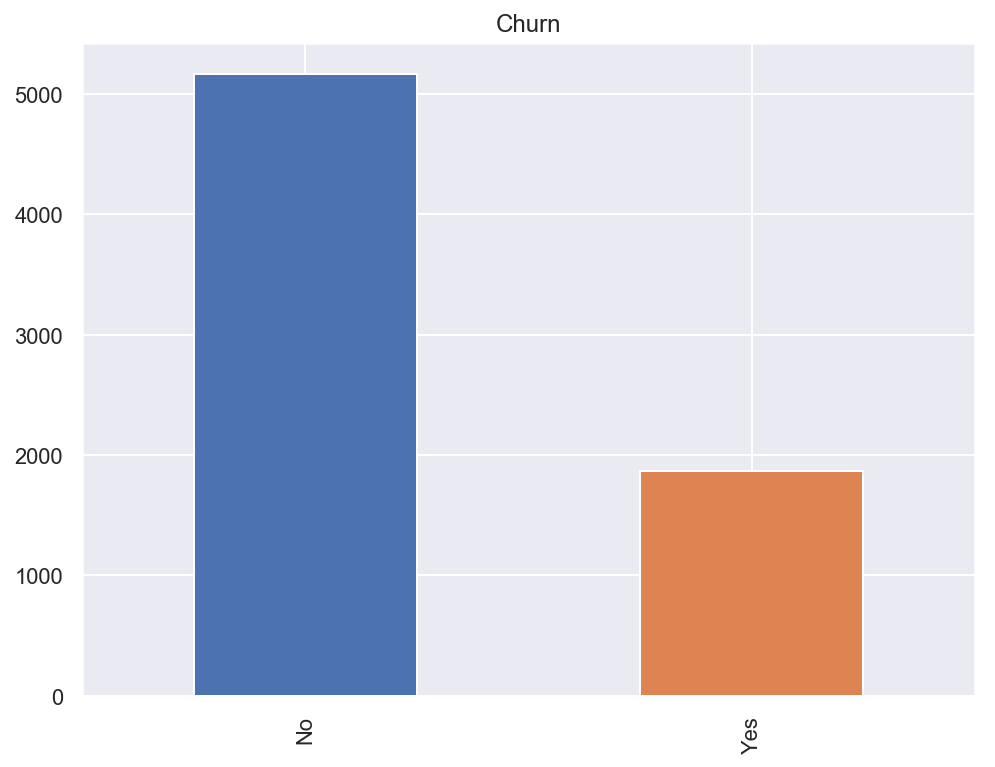

In [13]:
# Target variable distribution is not balanced as there are more non-churned than churned users
print(df.Churn.value_counts())
df['Churn'].value_counts().plot('bar').set_title('Churn')

In [9]:
1869/(5163+1869)

0.26578498293515357

In [10]:
# see all numerical columns
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [8]:
# replace values for SeniorCitizen
df['SeniorCitizen'] = df['SeniorCitizen'].replace({1:'Yes',0:'No'})

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


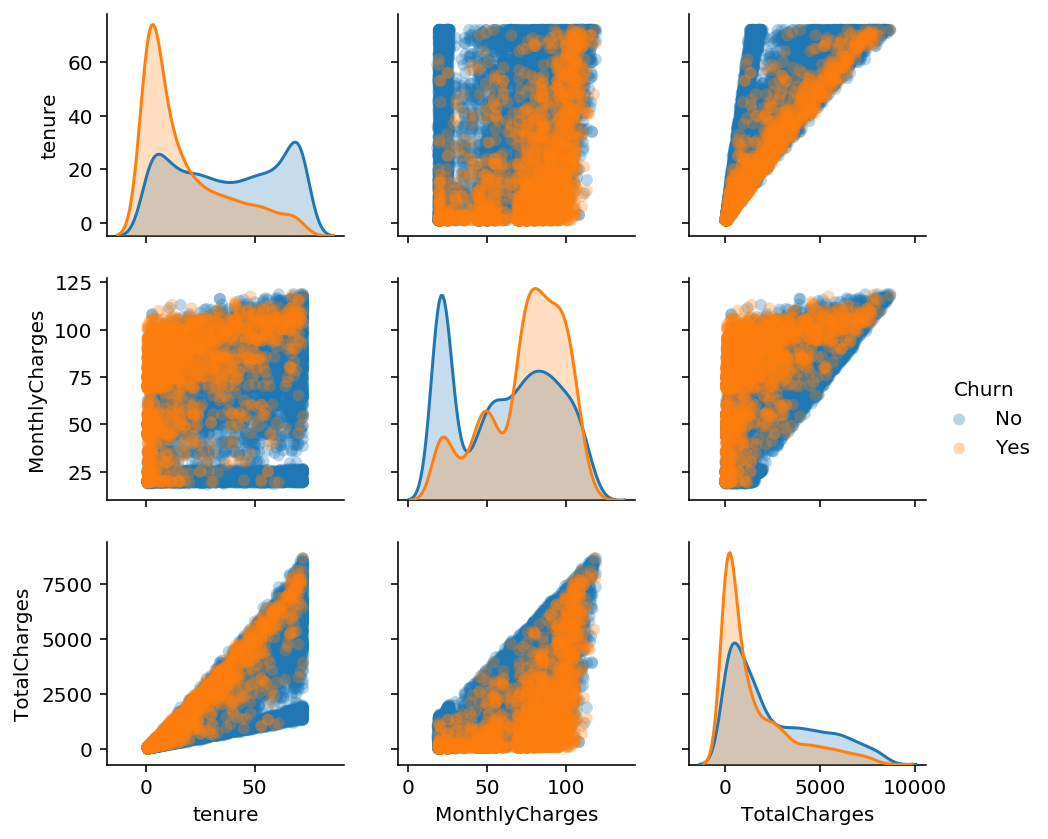

In [12]:
sns.pairplot(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']], 
             hue='Churn', plot_kws=dict(alpha=.3, edgecolor='none'), height=2, aspect=1.1);

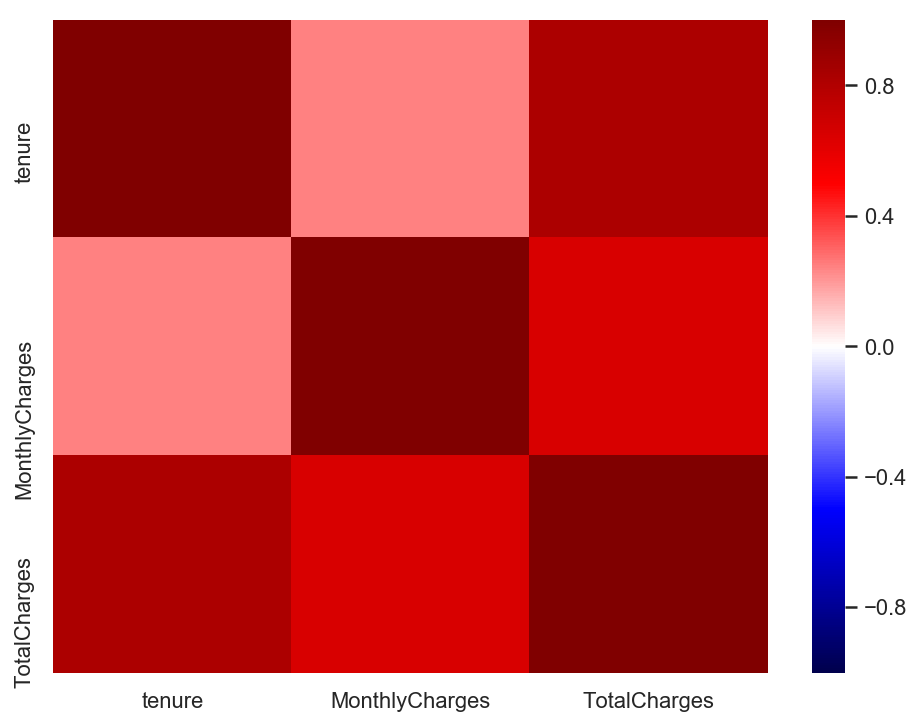

In [11]:
# Correlation Matrix for variables
sns.set(rc={'figure.figsize':(8,6)})
sns.heatmap(df.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000284756A5128>,
      dtype=object)

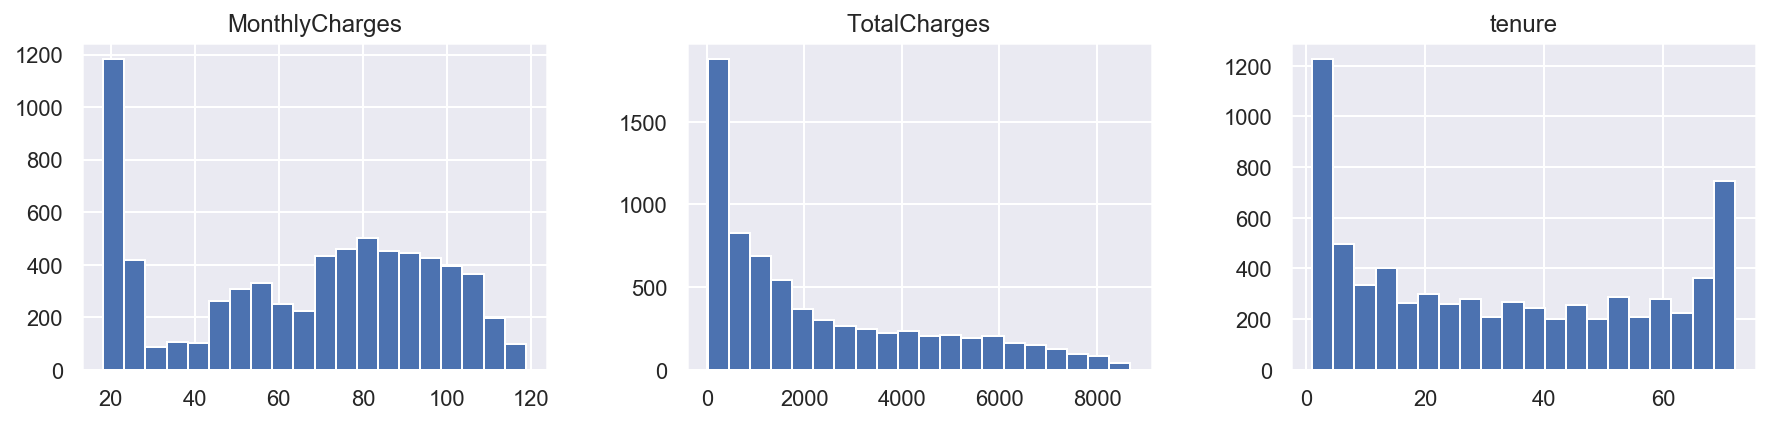

In [12]:
# to view numerical features in charts
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
df[num_cols].hist(bins=20, figsize=(10, 7), ax=ax)

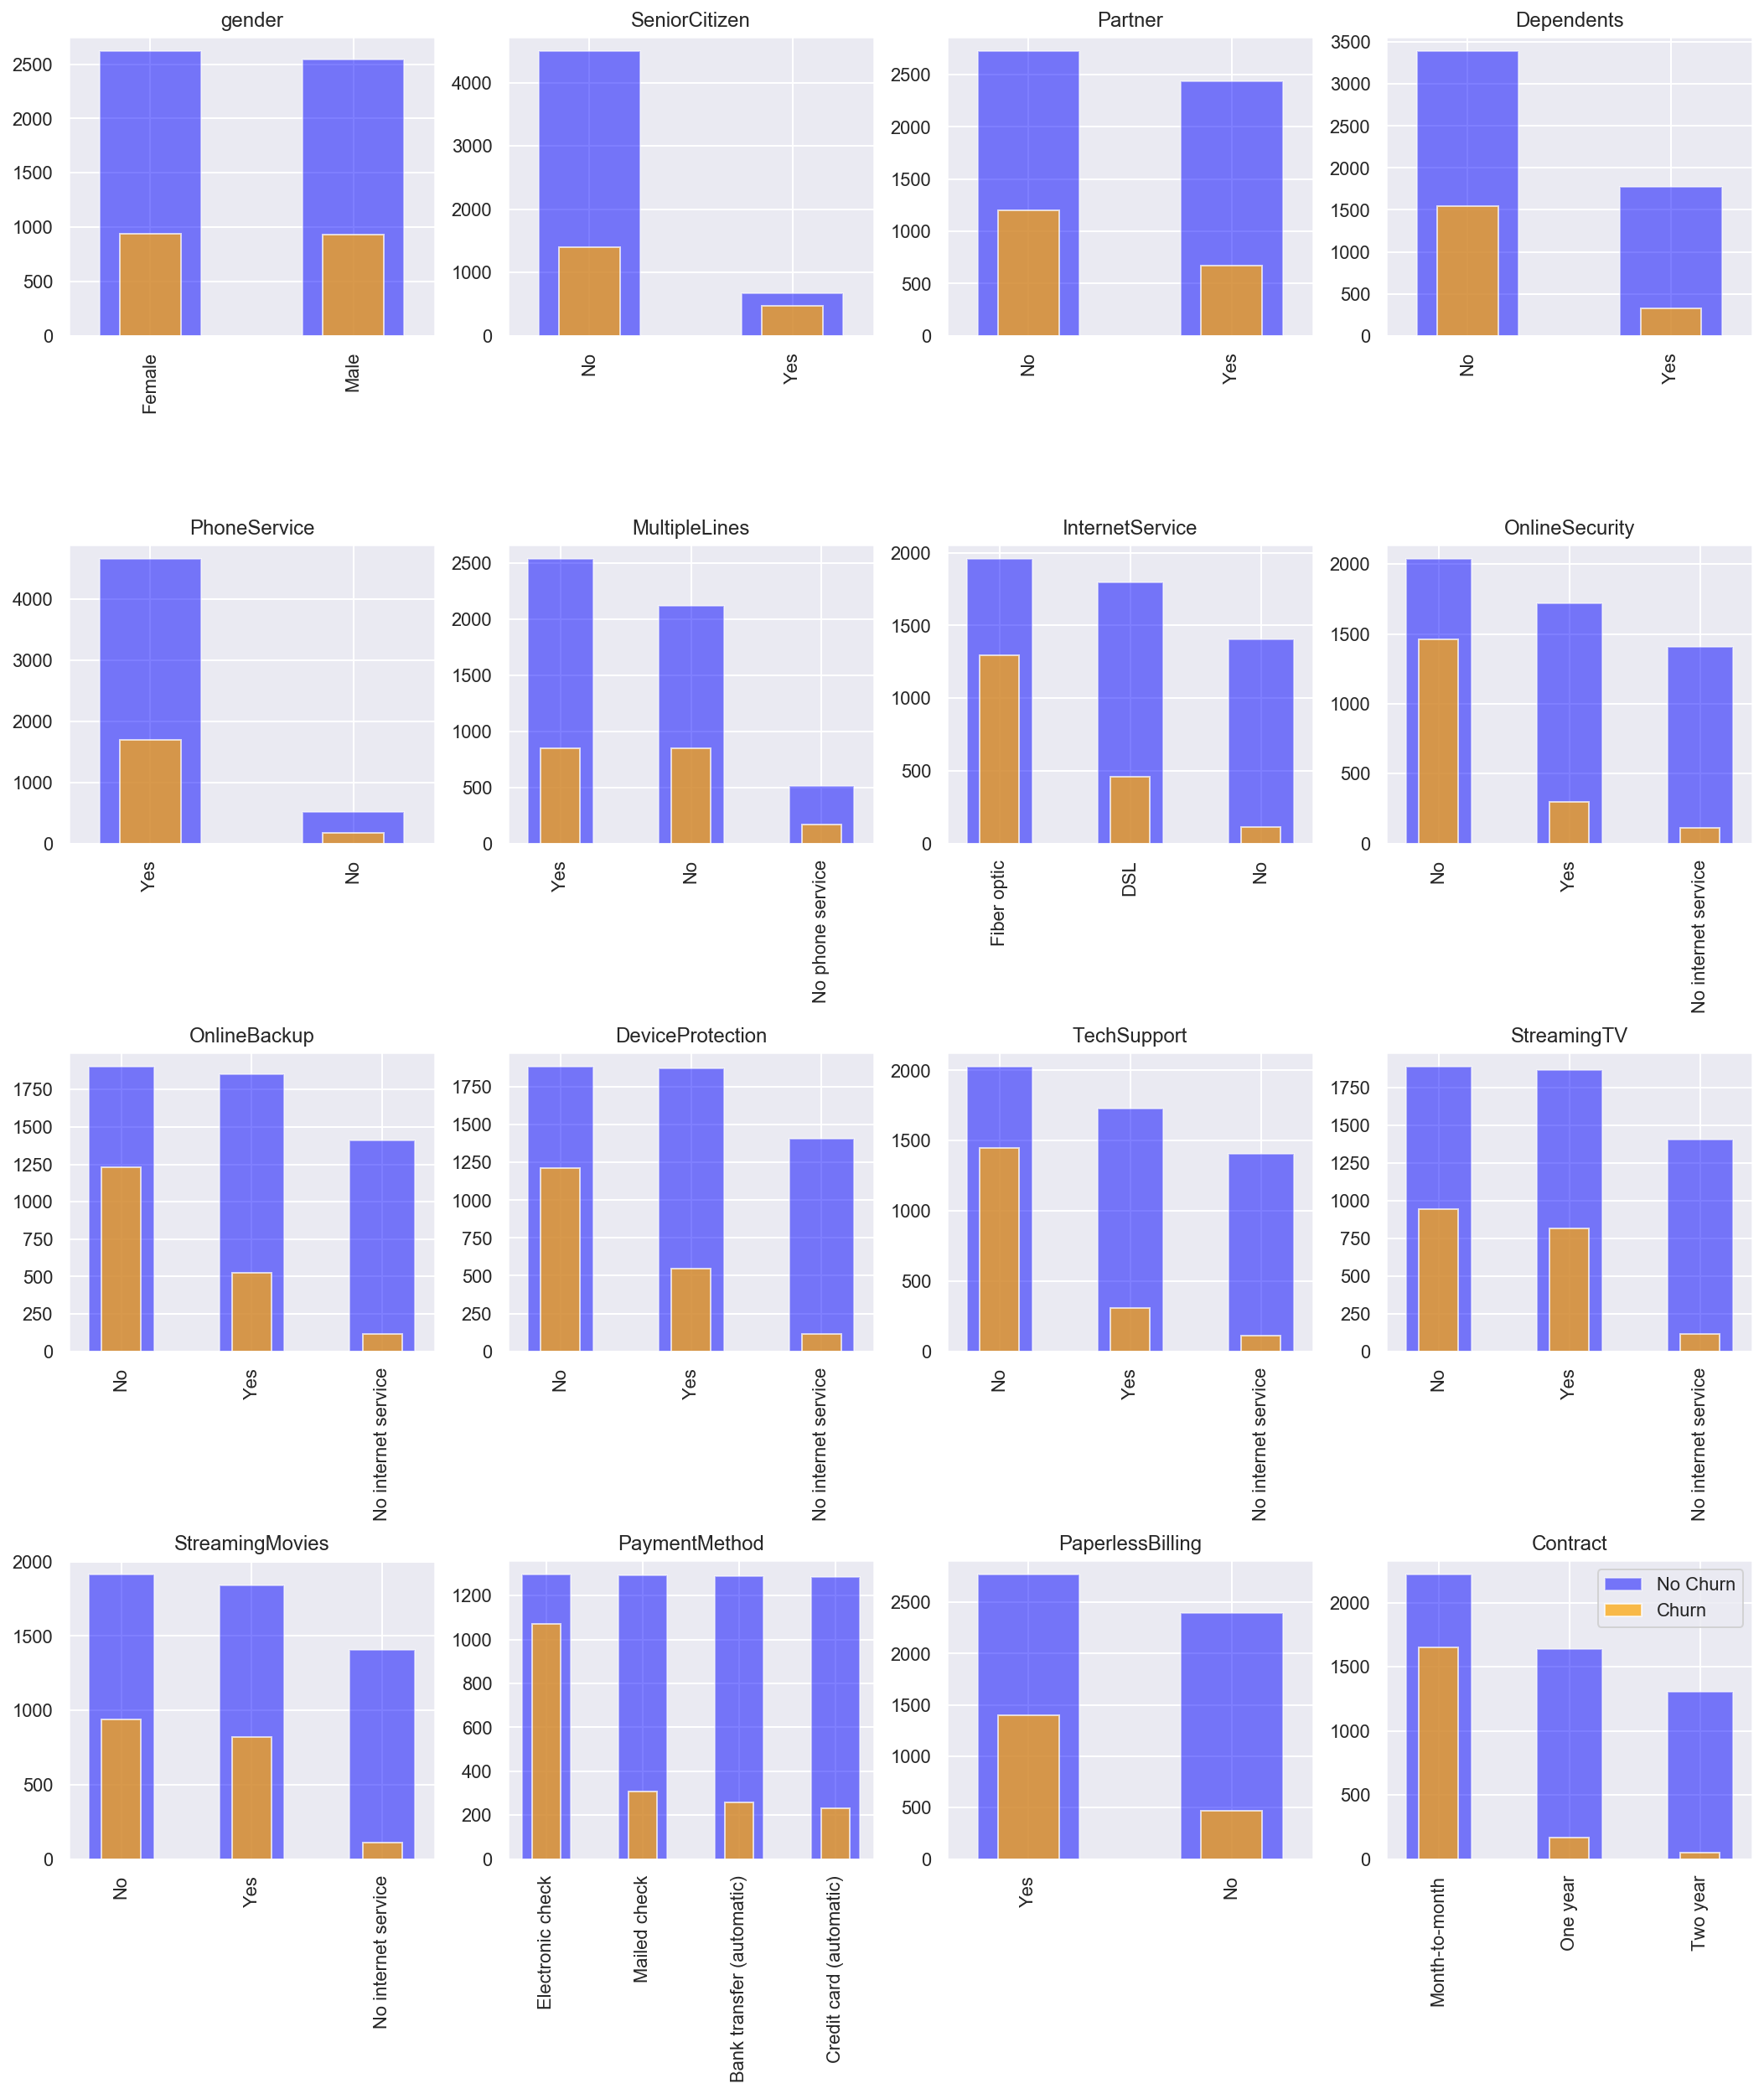

In [15]:
# To analyse categorical feature distribution
# Note: senior citizens and customers without phone service are minority (less represented) in the data
# Note: "No Internet Service" is a repeated feature in 6 other charts

categorical_features = [
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaymentMethod',
 'PaperlessBilling',
 'Contract' ]

ROWS, COLS = 4, 4
fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 20) )
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
#     df[categorical_feature].value_counts().plot('bar', ax=ax[row, col]).set_title(categorical_feature)
    df[df.Churn=='No'][categorical_feature].value_counts().plot('bar', 
                width=.5, ax=ax[row, col], color='blue', alpha=0.5).set_title(categorical_feature)
    df[df.Churn=='Yes'][categorical_feature].value_counts().plot('bar', 
                width=.3, ax=ax[row, col], color='orange', alpha=0.7).set_title(categorical_feature)
    plt.legend(['No Churn', 'Churn'])
    fig.subplots_adjust(hspace=0.7)

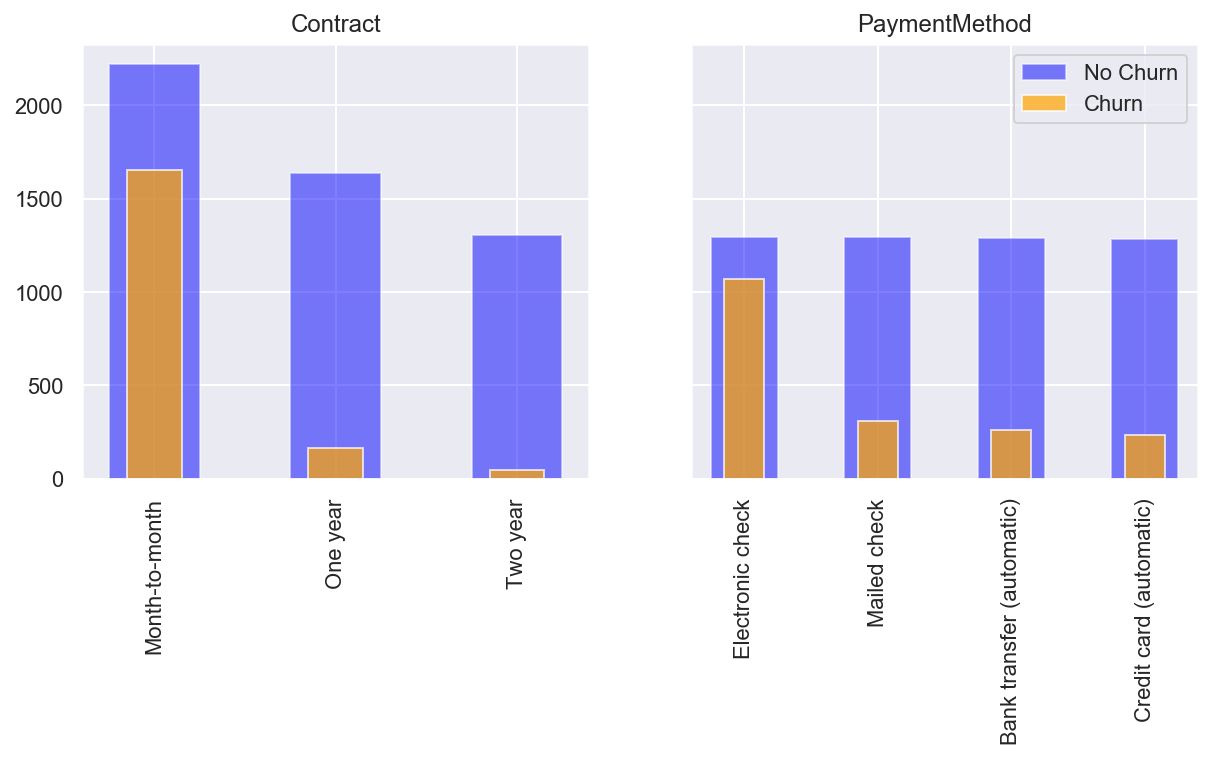

In [16]:
# to look at Contract & Payment Method in relation to the target variable
# note: users who have a month-to-month contract and Electronic check PaymentMethod are more likely to churn
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
df[df.Churn == 'No']['Contract'].value_counts().plot('bar', ax=ax[0], color='blue', alpha=0.5).set_title('Contract')
df[df.Churn == 'Yes']['Contract'].value_counts().plot('bar', width=.3, ax=ax[0], color='orange', alpha=0.7)
df[df.Churn == 'No']['PaymentMethod'].value_counts().plot('bar', ax=ax[1], color='blue', alpha=0.5).set_title('PaymentMethod')
df[df.Churn == 'Yes']['PaymentMethod'].value_counts().plot('bar', width=.3, ax=ax[1], color='orange', alpha=0.7)
plt.legend(['No Churn', 'Churn'])

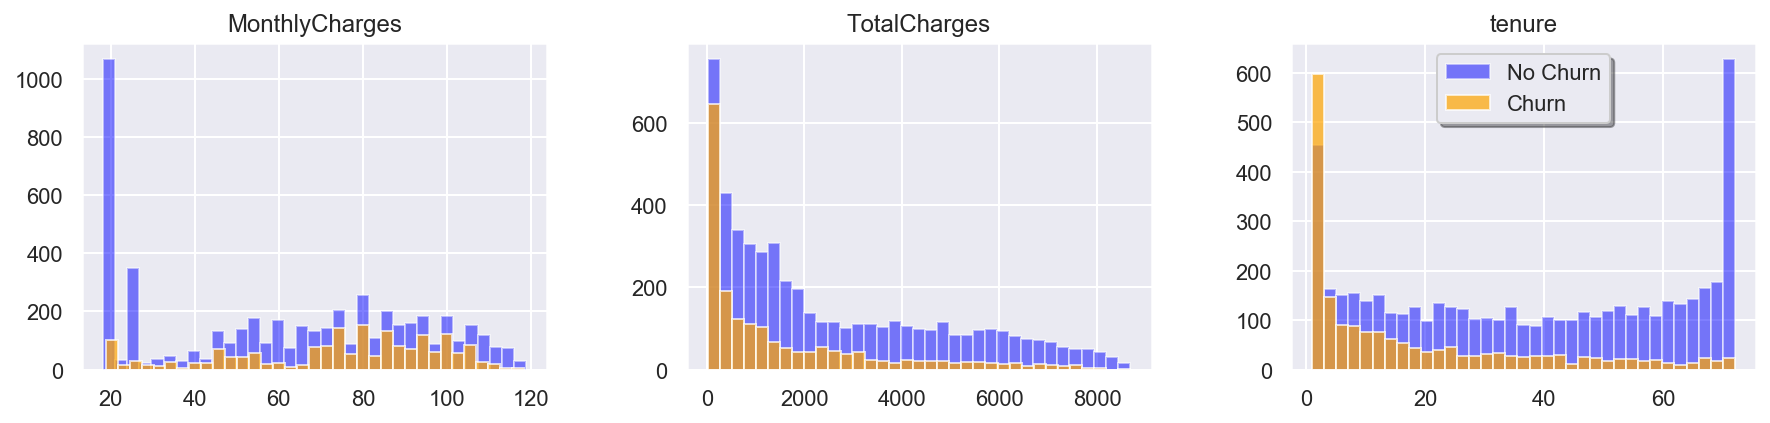

In [17]:
# look at distributions of numerical features in relation to the target variable
# the greater TotalCharges and tenure are the less is the probability of churn

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
df[df.Churn == "No"][num_cols].hist(bins=35, color="blue", alpha=0.5, ax=ax)
df[df.Churn == "Yes"][num_cols].hist(bins=35, color="orange", alpha=0.7, ax=ax)
plt.legend(['No Churn', 'Churn'], shadow=True, loc=9)

## Feature Engineering

In [18]:
# change MonthlyCharges to categorical column
def monthlycharges_split(df) :   
    if df['MonthlyCharges'] <= 30 :
        return '0-30'
    elif (df['MonthlyCharges'] > 30) & (df['MonthlyCharges'] <= 70 ):
        return '30-70'
    elif (df['MonthlyCharges'] > 70) & (df['MonthlyCharges'] <= 99 ):
        return '70-99'
    elif df['MonthlyCharges'] > 99 :
        return '99plus'
df['monthlycharges_group'] = df.apply(lambda df:monthlycharges_split(df), axis = 1)

# change TotalCharges to categorical column
def totalcharges_split(df) :   
    if df['TotalCharges'] <= 2000 :
        return '0-2k'
    elif (df['TotalCharges'] > 2000) & (df['TotalCharges'] <= 4000 ):
        return '2k-4k'
    elif (df['TotalCharges'] > 4000) & (df['TotalCharges'] <= 6000) :
        return '4k-6k'
    elif df['TotalCharges'] > 6000 :
        return '6kplus'
df['totalcharges_group'] = df.apply(lambda df:totalcharges_split(df), axis = 1)

# change Tenure to categorical column
def tenure_split(df) :   
    if df['tenure'] <= 20 :
        return '0-20'
    elif (df['tenure'] > 20) & (df['tenure'] <= 40 ):
        return '20-40'
    elif (df['tenure'] > 40) & (df['tenure'] <= 60) :
        return '40-60'
    elif df['tenure'] > 60 :
        return '60plus'
df['tenure_group'] = df.apply(lambda df:tenure_split(df), axis = 1)

# # Separating categorical and numerical columns
# Id_col     = ['customerID']
# target_col = ['Churn']
# cat_cols   = df.nunique()[df.nunique() < 6].keys().tolist()
# cat_cols   = [x for x in cat_cols if x not in target_col]
# num_cols   = [x for x in df.columns if x not in cat_cols + target_col + Id_col]

# target_col

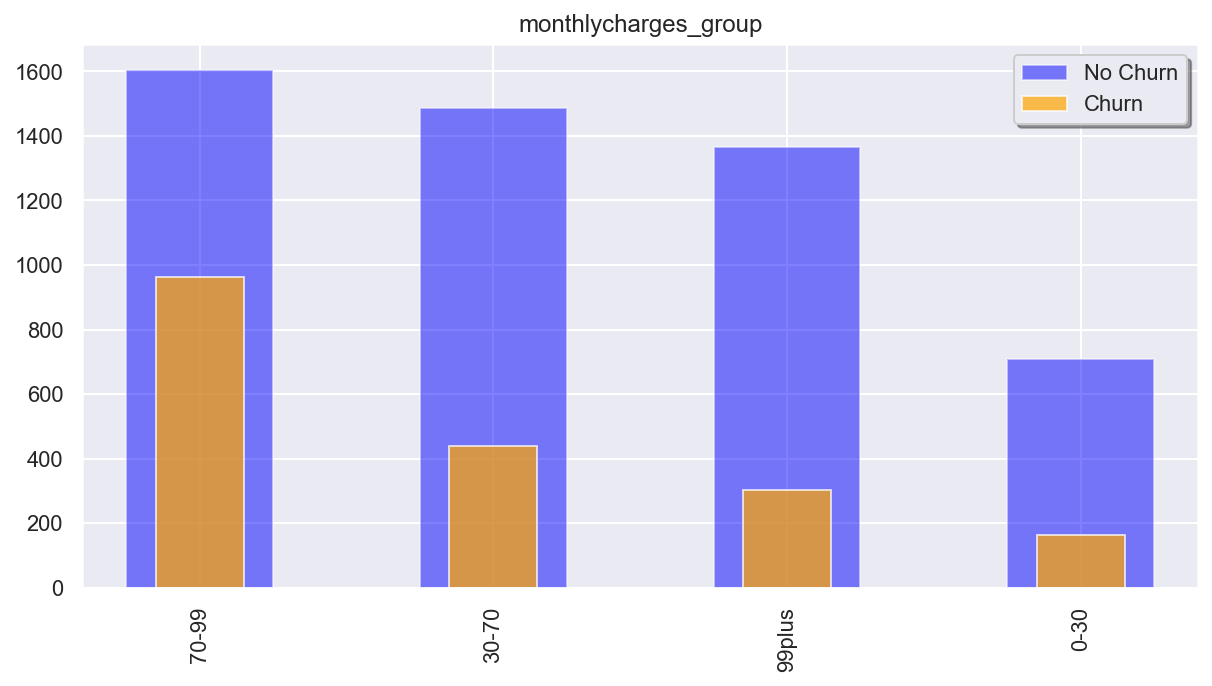

In [19]:
# new features monthlycharges_group
plt.figure(figsize = [10,5])
df[df.Churn == "No"]['monthlycharges_group'].value_counts().plot('bar', color="blue", alpha=0.5).set_title('monthlycharges_group')
df[df.Churn == "Yes"]['monthlycharges_group'].value_counts().plot('bar', color="orange", alpha=0.7, width=0.3)
plt.legend(['No Churn', 'Churn'], shadow=True, loc=1)

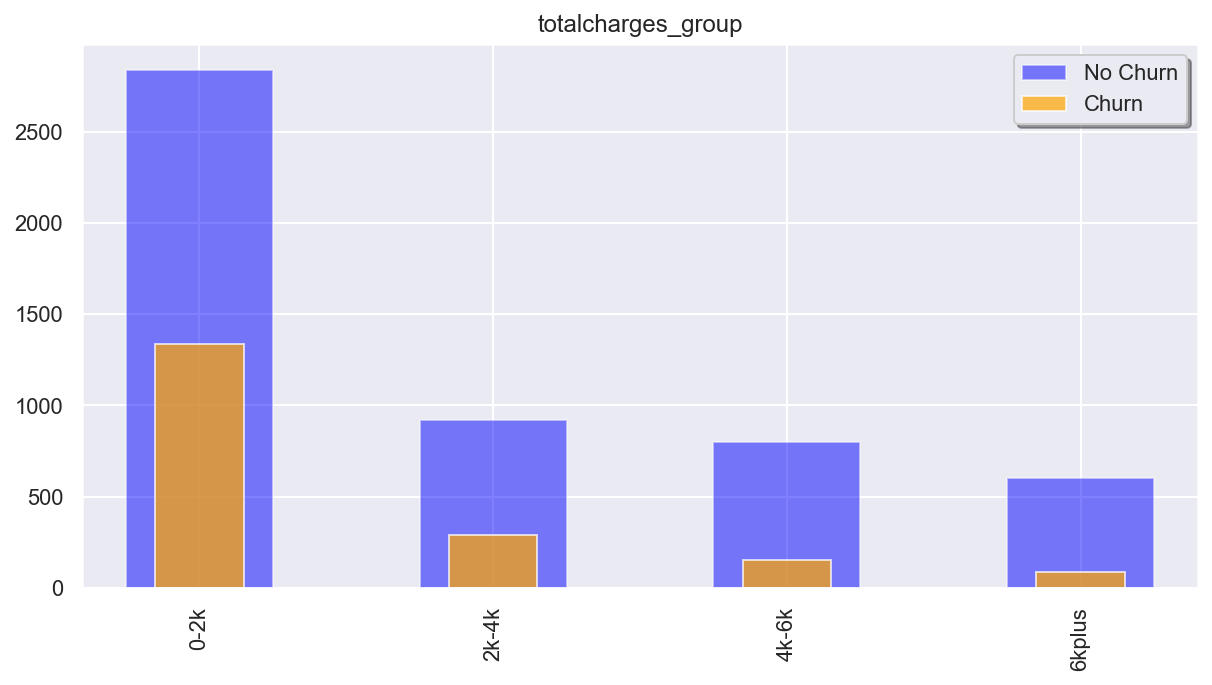

In [20]:
# new features totalcharges_group
plt.figure(figsize = [10,5])
df[df.Churn == "No"]['totalcharges_group'].value_counts().plot('bar', color="blue", alpha=0.5).set_title('totalcharges_group')
df[df.Churn == "Yes"]['totalcharges_group'].value_counts().plot('bar', color="orange", alpha=0.7, width=0.3)
plt.legend(['No Churn', 'Churn'], shadow=True, loc=1)

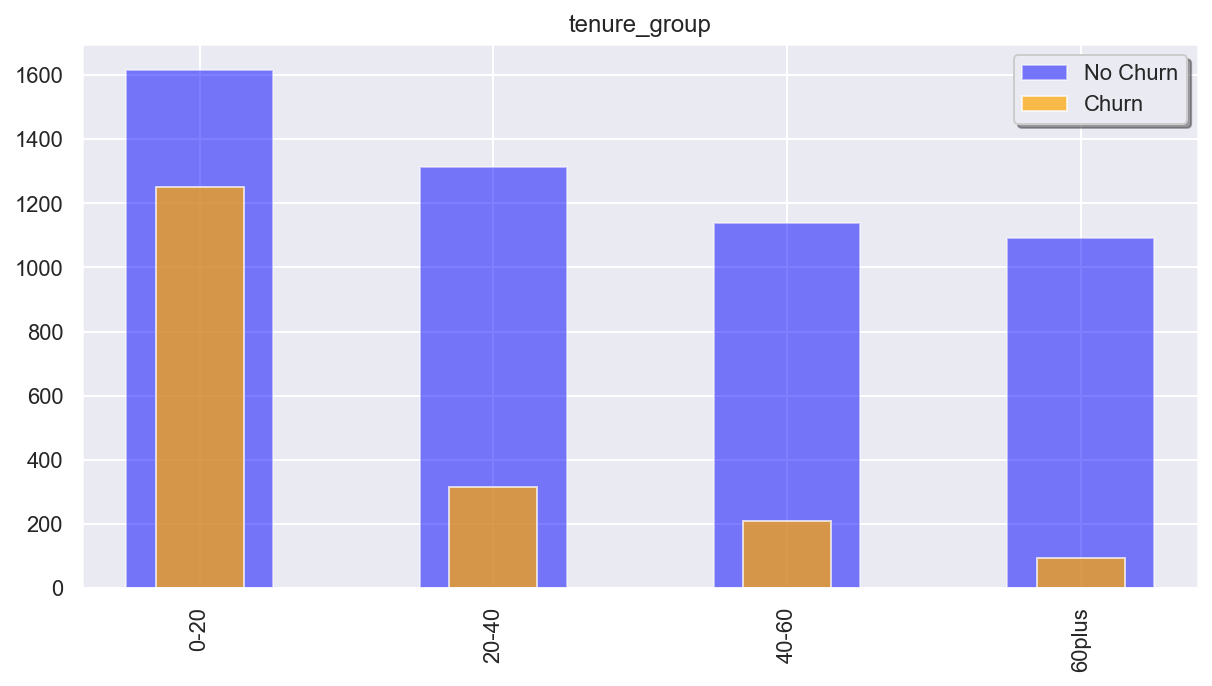

In [21]:
# new features tenure_group
plt.figure(figsize = [10,5])
df[df.Churn == "No"]['tenure_group'].value_counts().plot('bar', color="blue", alpha=0.5).set_title('tenure_group')
df[df.Churn == "Yes"]['tenure_group'].value_counts().plot('bar', color="orange", alpha=0.7, width=0.3)
plt.legend(['No Churn', 'Churn'], shadow=True, loc=1)

In [22]:
# store df to csv file
df.to_csv('df.csv', index=False)

# # backup original df for reference
# df_telcom_org = df.copy()   
# df_telcom_org

In [23]:
df = pd.read_csv('df.csv')

In [24]:
# Data preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# customer id col
Id_col     = ['customerID']
# Target columns
target_col = ['Churn']
#categorical columns
cat_cols   = df.nunique()[df.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in df.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = df.nunique()[df.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    df[i] = le.fit_transform(df[i])
    
#Duplicating columns for multi value columns
df = pd.get_dummies(data = df,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df1 = df.drop(columns = num_cols,axis = 1)
df1 = df1.merge(scaled, left_index=True, right_index=True, how = "left")

In [25]:
# check if there is any null fields
df1[df1.TotalCharges.isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No,MultipleLines_No phone service,...,totalcharges_group_2k-4k,totalcharges_group_4k-6k,totalcharges_group_6kplus,tenure_group_0-20,tenure_group_20-40,tenure_group_40-60,tenure_group_60plus,tenure,MonthlyCharges,TotalCharges


In [26]:
df1.describe()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,...,totalcharges_group_2k-4k,totalcharges_group_4k-6k,totalcharges_group_6kplus,tenure_group_0-20,tenure_group_20-40,tenure_group_40-60,tenure_group_60plus,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.00000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7.032000e+03,7.032000e+03,7.032000e+03
mean,0.504693,0.162400,0.482509,0.298493,0.903299,0.592719,0.265785,0.481371,0.096701,0.421928,...,0.171786,0.13595,0.098407,0.407708,0.200228,0.191980,0.200085,-1.214741e-16,9.652878e-17,-1.172113e-16
std,0.500014,0.368844,0.499729,0.457629,0.295571,0.491363,0.441782,0.499688,0.295571,0.493902,...,0.377221,0.34276,0.297886,0.491443,0.400199,0.393885,0.400092,1.000071e+00,1.000071e+00,1.000071e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.280248e+00,-1.547283e+00,-9.990692e-01
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.542963e-01,-9.709769e-01,-8.302488e-01
50%,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.394171e-01,1.845440e-01,-3.908151e-01
75%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,9.199259e-01,8.331482e-01,6.668271e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.612573e+00,1.793381e+00,2.824261e+00


In [27]:
df1.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'PaperlessBilling', 'Churn', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'P

In [28]:
df1.dtypes

customerID                                  object
gender                                       int32
SeniorCitizen                                int32
Partner                                      int32
Dependents                                   int32
PhoneService                                 int32
PaperlessBilling                             int32
Churn                                        int32
MultipleLines_No                             uint8
MultipleLines_No phone service               uint8
MultipleLines_Yes                            uint8
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No                           uint8
OnlineSecurity_No                            uint8
OnlineSecurity_No internet service           uint8
OnlineSecurity_Yes                           uint8
OnlineBackup_No                              uint8
OnlineBackup_No internet service             uint8
OnlineBackup_Yes               

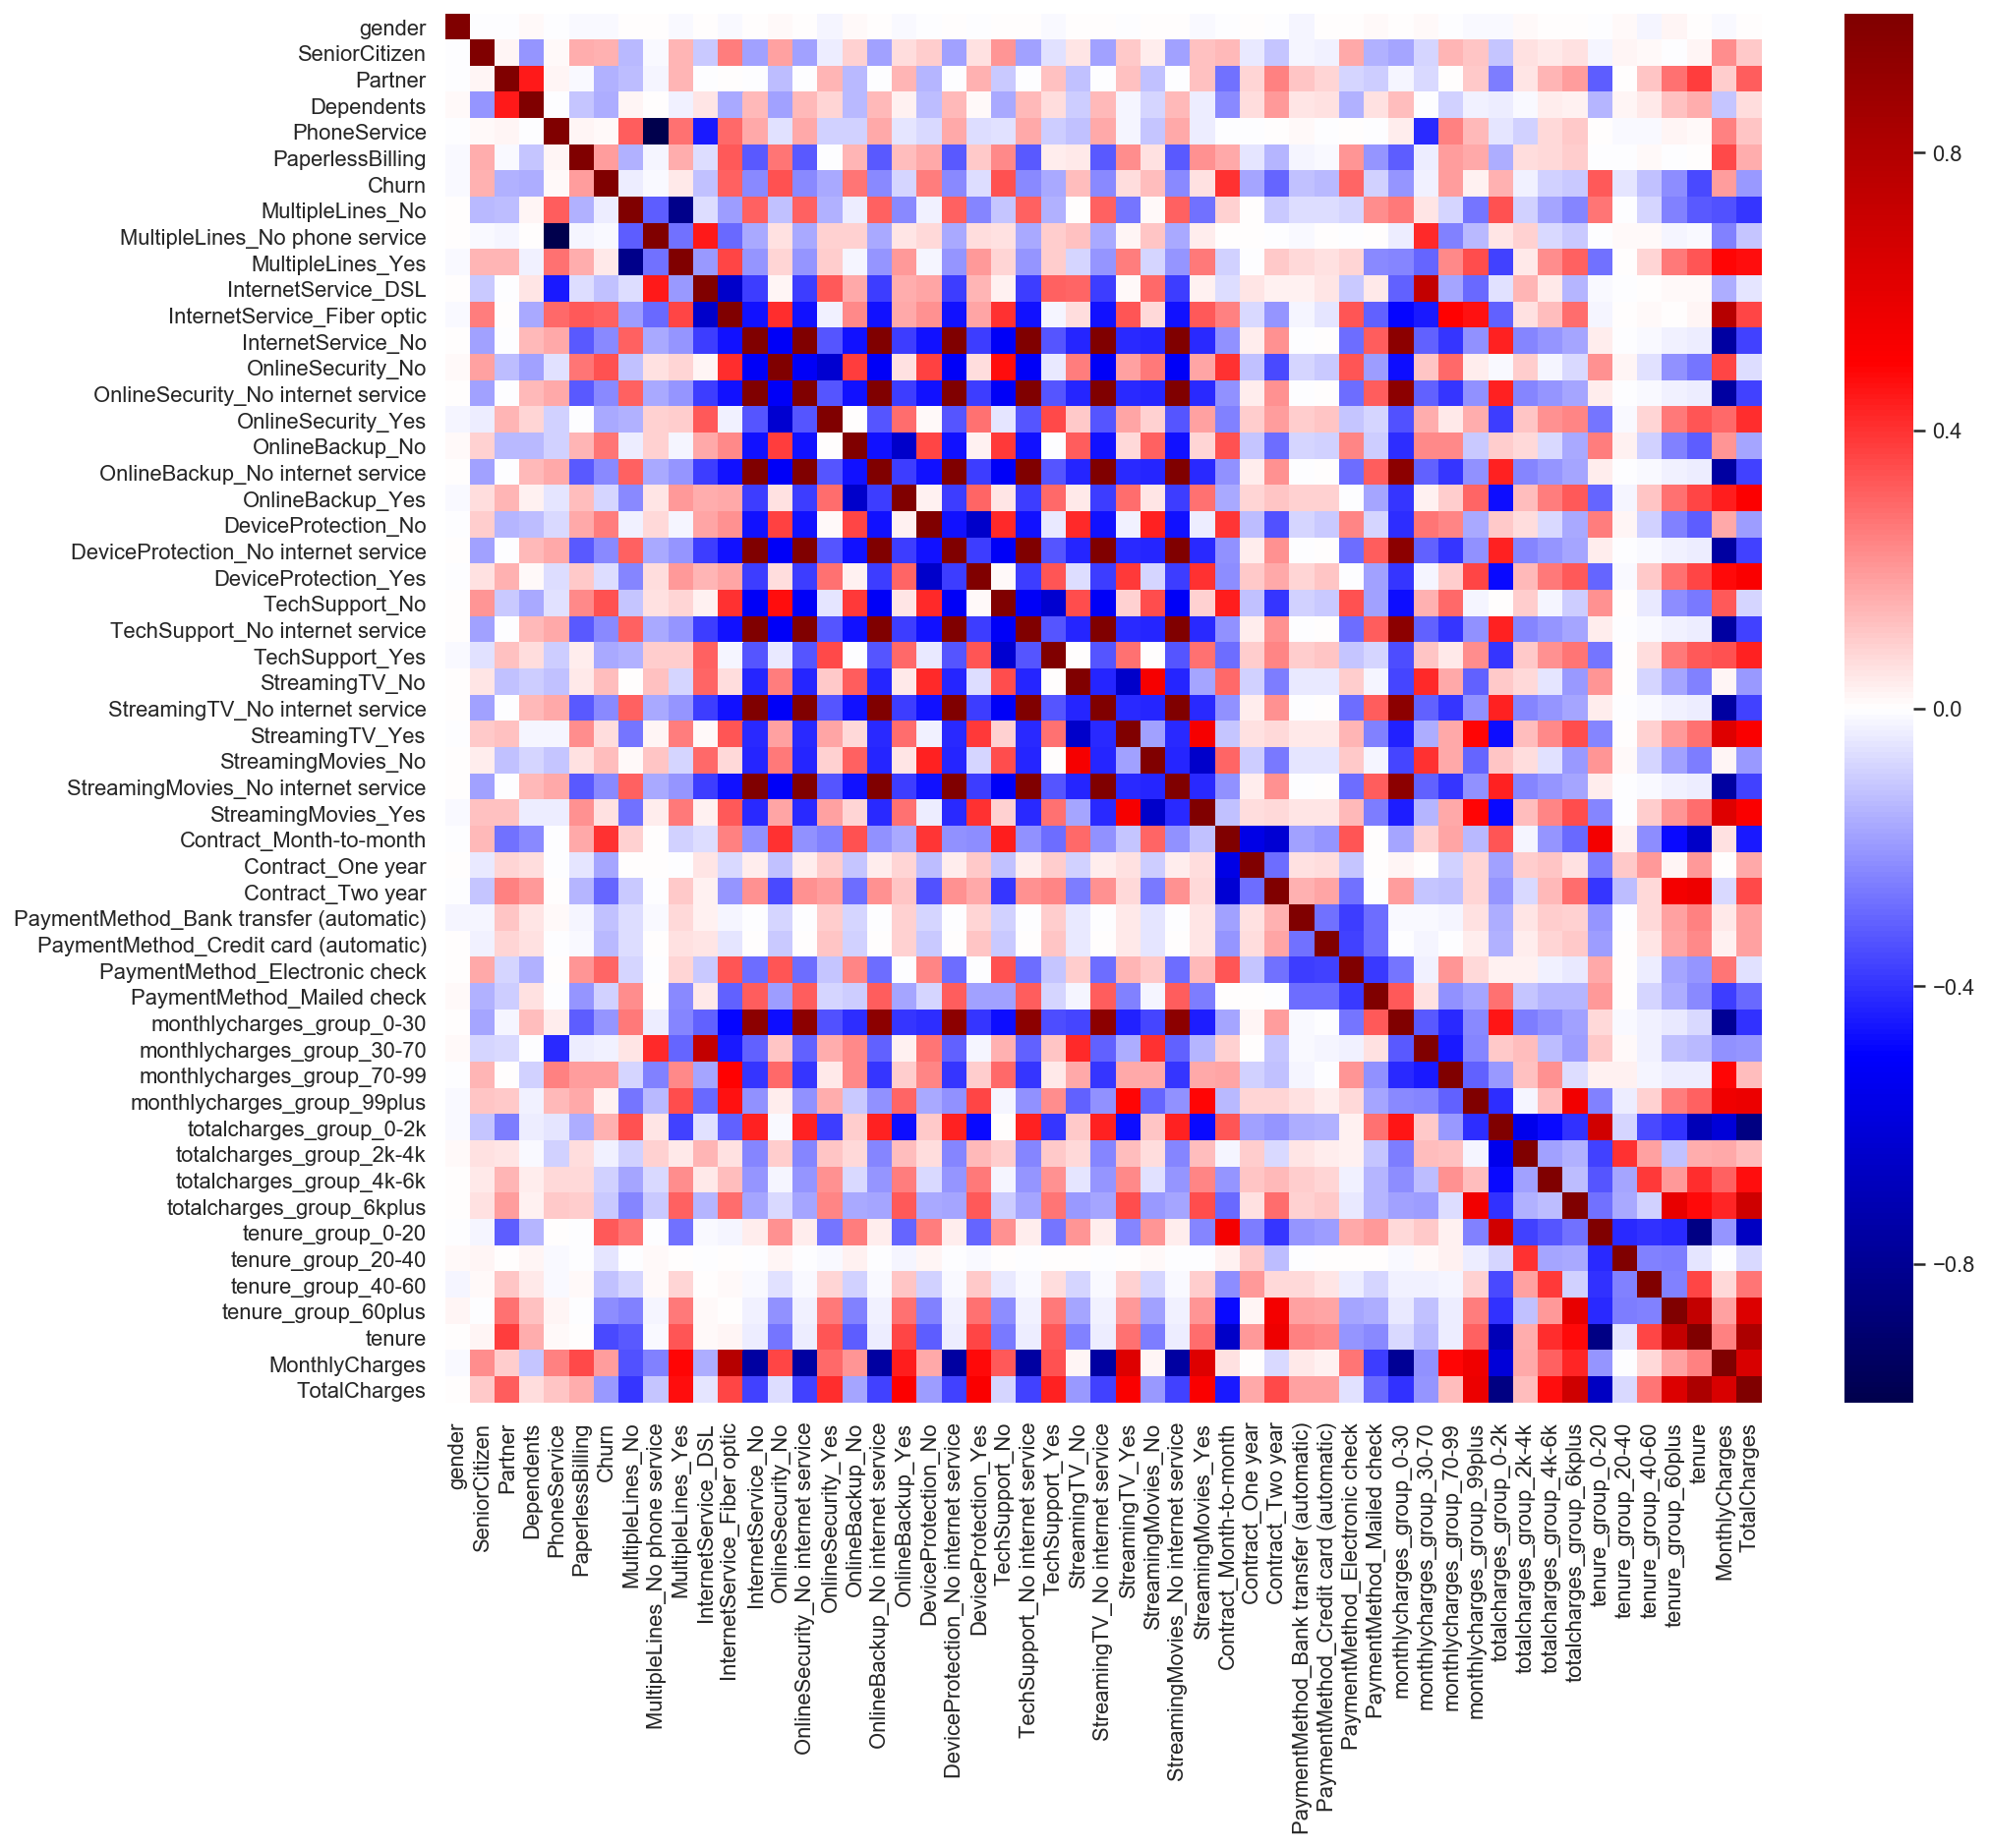

In [29]:
# Correlation Matrix for variables
sns.set(rc={'figure.figsize':(15,13)})
sns.heatmap(df1.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1)

In [30]:
# drop 'customerID' column, feature not needed in model selection
df1 = df1.drop('customerID', axis=1)

# there are a lot of repeated features (no internet service), so drop them
df1 = df1.drop(columns=['OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 
                        'DeviceProtection_No internet service', 'TechSupport_No internet service', 
                        'StreamingTV_No internet service', 'StreamingMovies_No internet service'], axis=1)

In [31]:
df1.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'PaperlessBilling', 'Churn', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_Yes', 'StreamingMovies_No',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'monthlycharges_group_0-30', 'monthlycharges_group_30-70',
       'monthlycharges_group_70-99', 'monthlycharges_group_99plus',
       'totalcharges_group_0-2k', 'totalcharges_group_2k-4k',
       

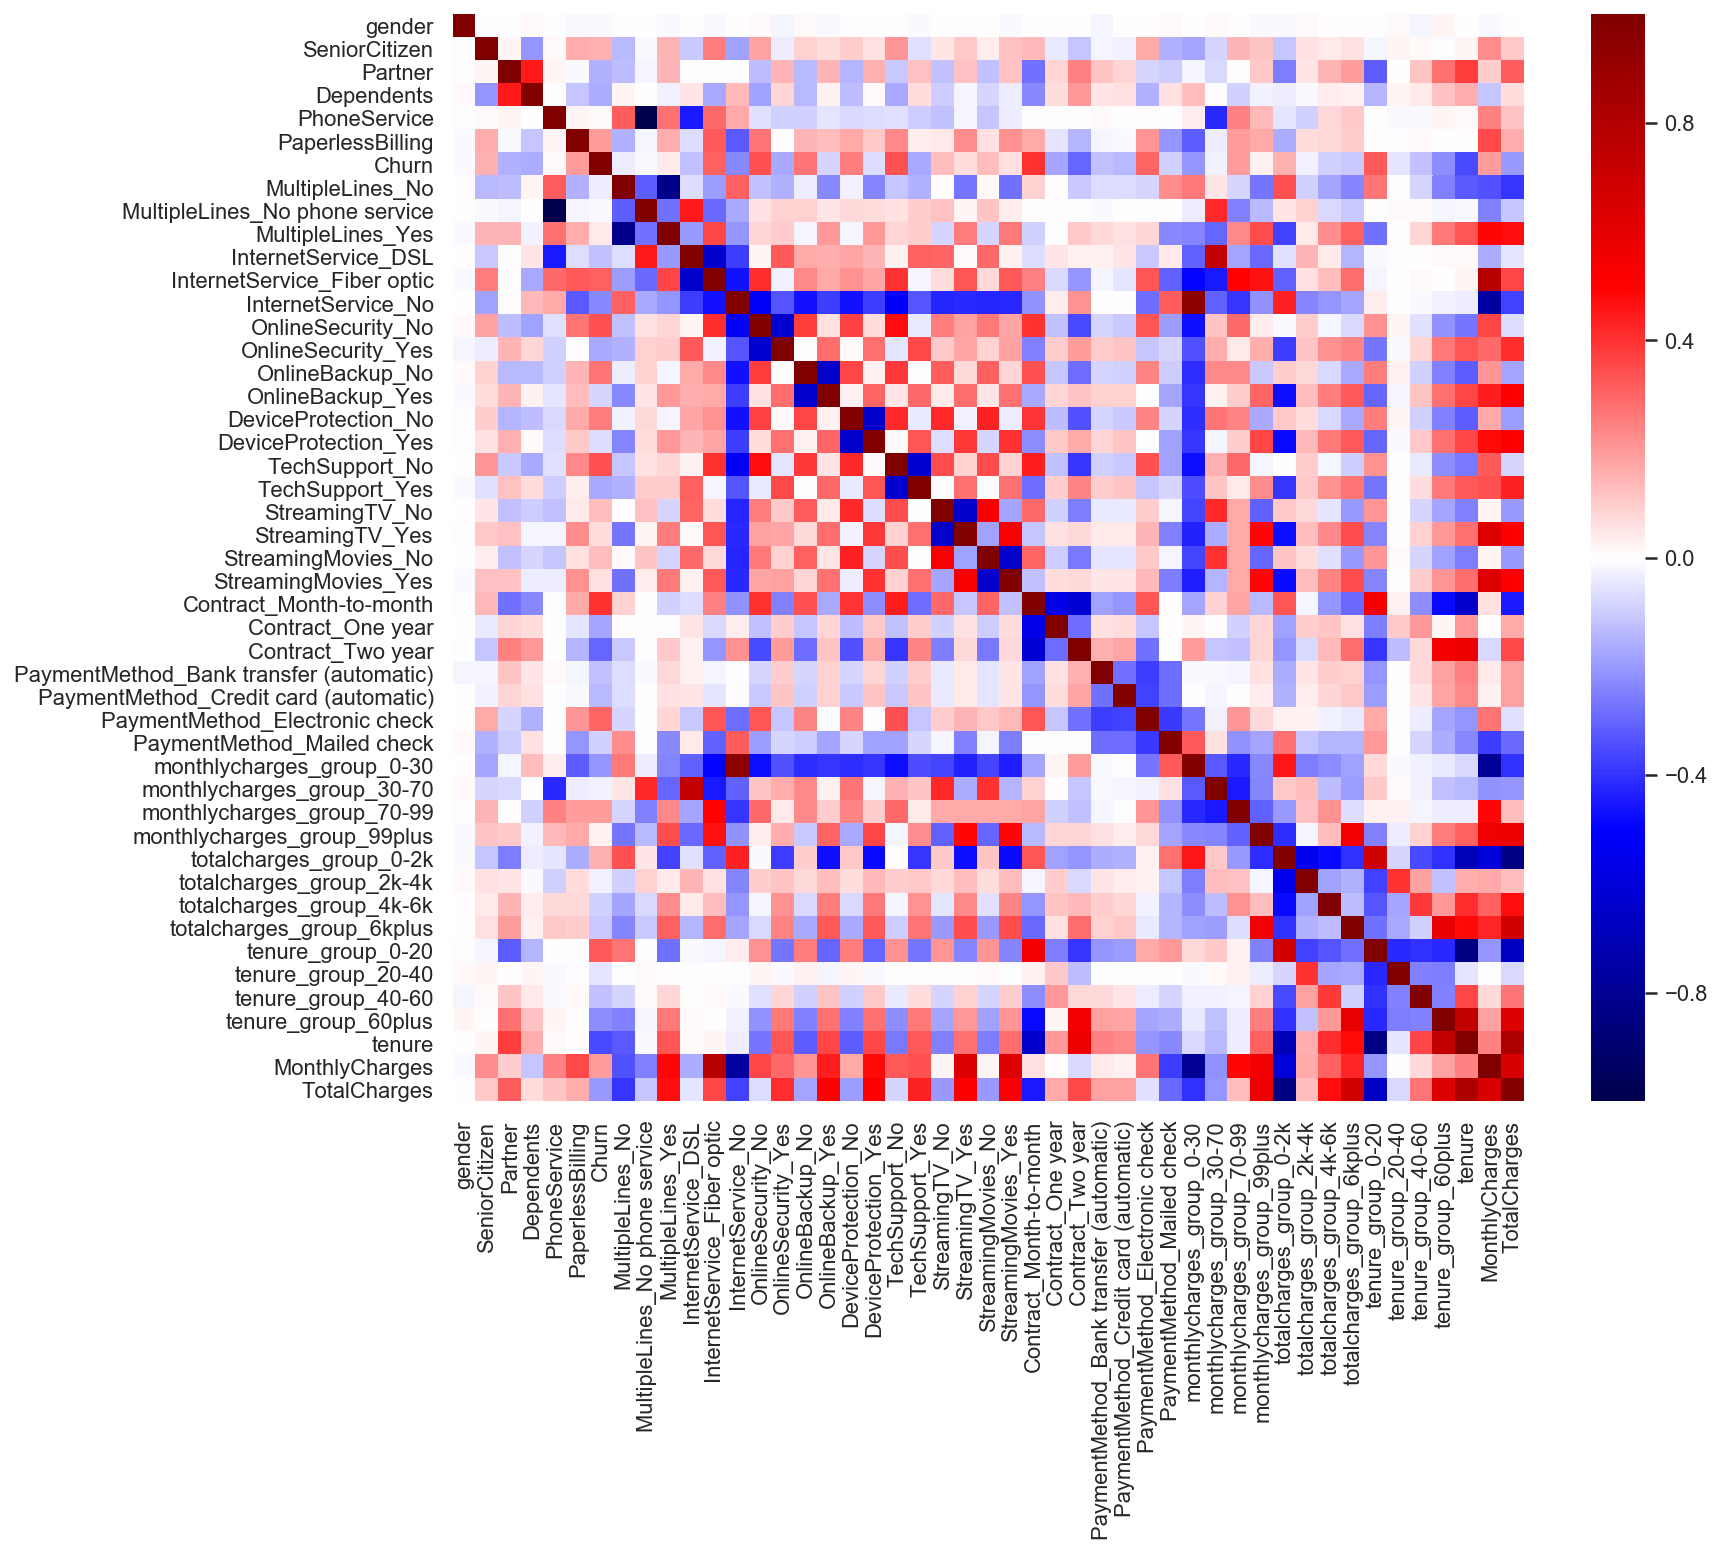

In [32]:
# Correlation Matrix for variables
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(df1.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1)

In [33]:
# store df1 to csv file
df1.to_csv('df1.csv', index=False)

## Feature Selection

In [34]:
df1 = pd.read_csv('df1.csv')

In [35]:
X, y = df1.drop('Churn',axis=1), df1[['Churn']]

import statsmodels.api as sm
X = sm.add_constant(X)  # need to add this to define the Intercept
# model / fit / summarize results
model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Churn   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     92.94
Date:                Sun, 18 Aug 2019   Prob (F-statistic):               0.00
Time:                        19:19:42   Log-Likelihood:                -2987.7
No. Observations:                7032   AIC:                             6041.
Df Residuals:                    6999   BIC:                             6268.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.0244      0.051      0.479      0.632      -0.076       0.124
gender                                     -0.0042      0.009     -0.478      0.633      -0.022       0.013
SeniorCitizen                               0.0462      0.013      3.582      0.000       0.021       0.071
Partner                                     0.0032      0.011      0.295      0.768      -0.018       0.024
Dependents                                 -0.0169      0.011     -1.487      0.137      -0.039       0.005
PhoneService                                0.0256      0.020      1.281      0.200      -0.014       0.065
PaperlessBilling                            0.0432      0.010      4.365      0.000       0.024       0.063
MultipleLines_No                           -0.0205      0.006     -3.386      0.001      -0.032      -0.009
MultipleLines_No phone service             -0.0012      0.070     -0.018      0.986      -0.139       0.136
MultipleLines_Yes                           0.0461      0.021      2.157      0.031       0.004       0.088
InternetService_DSL                        -0.0639      0.033     -1.947      0.052      -0.128       0.000
InternetService_Fiber optic                 0.1441      0.076      1.886      0.059      -0.006       0.294
InternetService_No                         -0.0557      0.095     -0.584      0.559      -0.243       0.131
OnlineSecurity_No                           0.0578      0.013      4.442      0.000       0.032       0.083
OnlineSecurity_Yes                          0.0223      0.034      0.662      0.508      -0.044       0.088
OnlineBackup_No                             0.0451      0.013      3.491      0.000       0.020       0.070
OnlineBackup_Yes                            0.0350      0.034      1.042      0.297      -0.031       0.101
DeviceProtection_No                         0.0367      0.013      2.825      0.005       0.011       0.062
DeviceProtection_Yes                        0.0434      0.034      1.290      0.197      -0.023       0.109
TechSupport_No                              0.0582      0.013      4.441      0.000       0.033       0.084
TechSupport_Yes                             0.0219      0.034      0.651      0.515      -0.044       0.088
StreamingTV_No                              0.0065      0.007      0.965      0.335      -0.007       0.020
StreamingTV_Yes                             0.0736      0.044      1.666      0.096      -0.013       0.160
StreamingMovies_No                          0.0072      0.007      1.070      0.285      -0.006       0.020
StreamingMovies_Yes                         0.0729      0.044      1.650      0.099      -0.014       0.160
Contract_Month-to-month                     0.0727      0.0

In [36]:
## to find best alpha for LassoCV (all X_scaled)

from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

print('Use LassoCV to find the optimal ALPHA value for L1 regularization')
# Scale the Predictors on both the train and validation set
std = StandardScaler()
std.fit(X.values)
X_scaled = std.transform(X.values)
print('X_scaled', X_scaled.shape)
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-3,3,200)   # alpha varies from 0.001 to 1000
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_scaled, y)
# This is the best alpha value found
print('LASSO best alpha: ', lasso_model.alpha_ )
# display all coefficients in the model with optimal alpha
list(zip(X.columns, lasso_model.coef_)) 

Use LassoCV to find the optimal ALPHA value for L1 regularization
X_scaled (7032, 47)
LASSO best alpha:  0.001


[('const', 0.0),
 ('gender', -0.0010661891915392779),
 ('SeniorCitizen', 0.01646273843460923),
 ('Partner', 0.0),
 ('Dependents', -0.006895811117057325),
 ('PhoneService', -0.0),
 ('PaperlessBilling', 0.02096500564180682),
 ('MultipleLines_No', -0.01940146380136624),
 ('MultipleLines_No phone service', 0.0),
 ('MultipleLines_Yes', 0.005685987934927271),
 ('InternetService_DSL', -0.0),
 ('InternetService_Fiber optic', 0.07579327144723144),
 ('InternetService_No', -0.007475182669470224),
 ('OnlineSecurity_No', 0.024814868019476813),
 ('OnlineSecurity_Yes', -0.0),
 ('OnlineBackup_No', 0.010882516512912405),
 ('OnlineBackup_Yes', -0.0),
 ('DeviceProtection_No', 0.002347586851428413),
 ('DeviceProtection_Yes', -0.0),
 ('TechSupport_No', 0.024740875398156482),
 ('TechSupport_Yes', -0.0),
 ('StreamingTV_No', -0.0),
 ('StreamingTV_Yes', 0.020401788347634894),
 ('StreamingMovies_No', -0.0),
 ('StreamingMovies_Yes', 0.02019531096009362),
 ('Contract_Month-to-month', 0.04663630636913941),
 ('Cont

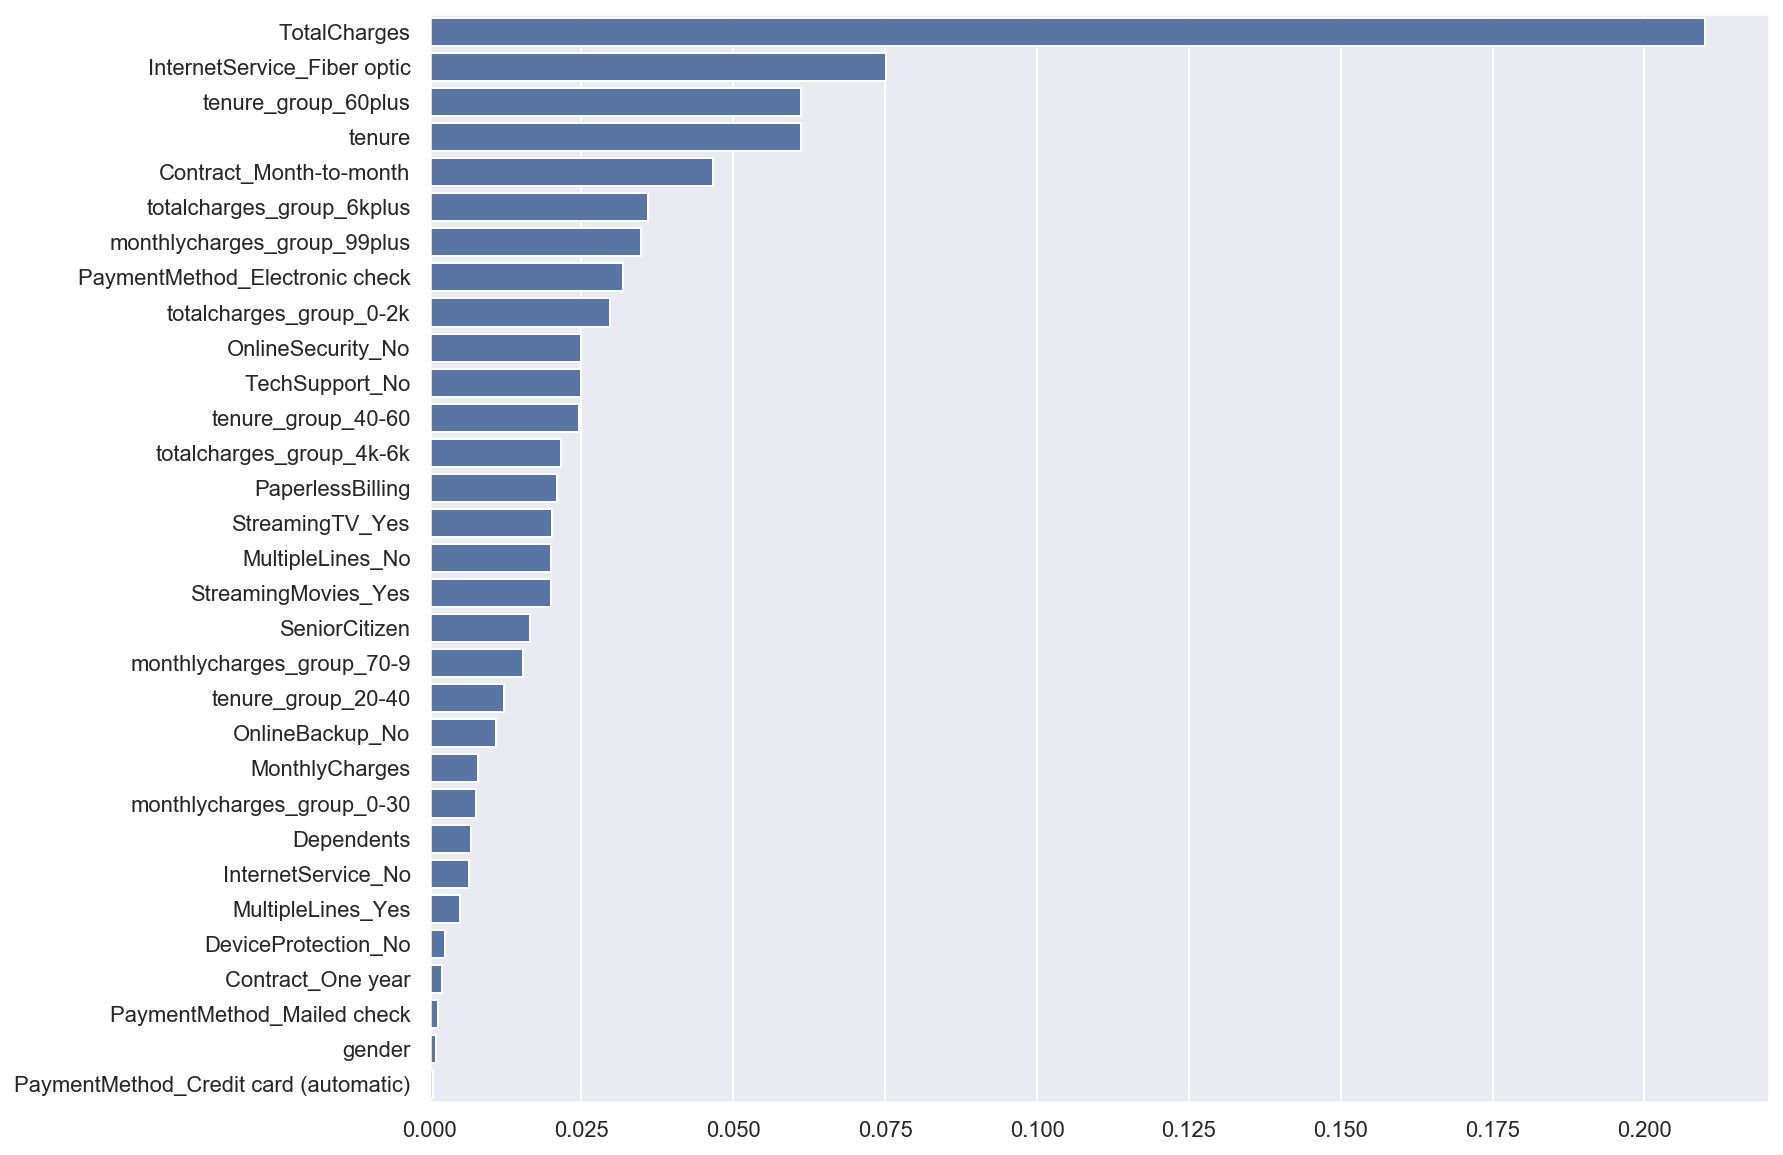

In [37]:
plot_feature = ['TotalCharges', 'InternetService_Fiber optic', 'tenure_group_60plus', 'tenure', 'Contract_Month-to-month', 
                'totalcharges_group_6kplus', 'monthlycharges_group_99plus', 'PaymentMethod_Electronic check', 
                'totalcharges_group_0-2k', 'OnlineSecurity_No', 'TechSupport_No', 'tenure_group_40-60', 
                'totalcharges_group_4k-6k', 'PaperlessBilling', 'StreamingTV_Yes', 'MultipleLines_No', 'StreamingMovies_Yes', 
                'SeniorCitizen', 'monthlycharges_group_70-9', 'tenure_group_20-40', 'OnlineBackup_No', 'MonthlyCharges', 
                'monthlycharges_group_0-30', 'Dependents', 'InternetService_No', 'MultipleLines_Yes', 'DeviceProtection_No', 
                'Contract_One year', 'PaymentMethod_Mailed check', 'gender', 'PaymentMethod_Credit card (automatic)']

lasso_coeff = [0.209954752, 0.075144498, 0.061184581, 0.061182631, 0.046630292, 0.036007041, 0.034846244, 0.031775227, 
               0.029645254, 0.024949481, 0.024875392, 0.024679595, 0.021639644, 0.020966614, 0.020143496, 0.019954793, 
               0.019936301, 0.016463024, 0.015436581, 0.012221305, 0.011015587, 0.008054301, 0.007701626, 0.006895811, 
               0.00642757, 0.005009993, 0.002481356, 0.002102214, 0.001449537, 0.001066809, 0.000525379]

sns.barplot(y = plot_feature, x = lasso_coeff, color='b')

## Model Selection

In [38]:
df1 = pd.read_csv('df1.csv')
X, y = df1.drop('Churn',axis=1), df1[['Churn']]

In [ ]:
# # This section is used to select the top features (subset, instead of all features) to run on the model 
# X = df1[ ['tenure_group_0-20', 'tenure_group_60plus', 'monthlycharges_group_0-30', 'monthlycharges_group_70-99', 
#           'totalcharges_group_6kplus', 'totalcharges_group_0-2k', 'SeniorCitizen', 'InternetService_Fiber optic', 
#           'InternetService_No', 'OnlineSecurity_No', 'OnlineBackup_No', 'DeviceProtection_No', 'TechSupport_No', 
#           'PaymentMethod_Electronic check', 'PaymentMethod_Credit card (automatic)', 'PaperlessBilling', 
#           'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'StreamingTV_No', 'StreamingMovies_No', 
#           'TotalCharges', 'tenure'] ]
# y = df1[['Churn']]

In [96]:
# split data to 80:20 ratio for train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=71)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

def model_report(model_name, model):
    print('\nSearch for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data')
    model.fit(X_train, y_train)
    
    optimal_th = 0.5
    iteration = [np.linspace(optimal_th-0.4999, optimal_th+0.4999, 11), 
                  # eg, [ 0.0001 , 0.1008, 0.2006, 0.3004, 0.4002, 0.5, 0.5998, 0.6996, 0.7994, 0.8992, 0.9999 ]
                 np.linspace(optimal_th-0.1, optimal_th+0.1, 21), 
                  # eg, [ 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ]
                 np.linspace(optimal_th-0.01, optimal_th+0.01, 21)]
                  # eg, [ 0.29 , 0.291, 0.292, 0.293, 0.294, 0.295, 0.296, 0.297, 0.298, 0.299, 0.3  , 0.301, 0.302, 0.303, 0.304, 0.305, 0.306, 0.307, 0.308, 0.309, 0.31 ]
    
    for i in range(0,3):
        score_list, th_list = [], []
        print('\nLooping decimal place', i+1) 
        for th in iteration[i]:
            y_pred = (model.predict_proba(X_test)[:,1] >= th)   
            score_list.append(f1_score(y_test, y_pred))    
            th_list.append(th)
            print('{:.4f}->{:.4f}'.format(th, f1_score(y_test, y_pred)), end=',  ')   # 4 decimal pl
        optimal_th = float(th_list[score_list.index(max(score_list))])

    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    print('optimal threshold = {:.4f}'.format(optimal_th))

    print(model_name, 'accuracy score is')
    print('Training: {:.2f}%'.format(100*model.score(X_train, y_train)))  # score uses accuracy
    print('Test set: {:.2f}%'.format(100*model.score(X_test, y_test)))   # should use cross validation

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.25)
    print('\nAdjust threshold to 0.25:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = model.predict(X_test)
    print('\nDefault threshold of 0.50:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.75)
    print('\nAdjust threshold to 0.75:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= optimal_th)
    print('\nOptimal threshold {:.4f}'.format(optimal_th))
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))
    
    global model_f1, model_auc, model_ll, model_roc_auc
    model_f1 = f1_score(y_test, y_pred)

    y_pred = model.predict_proba(X_test)
    model_ll = log_loss(y_test, y_pred)
    print(model_name, 'Log-loss: {:.4f}'.format(model_ll))
    y_pred = model.predict(X_test)
    model_roc_auc = roc_auc_score(y_test, y_pred)
    print(model_name, 'roc_auc_score: {:.4f}'.format(model_roc_auc)) 
    y_pred = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    model_auc = auc(fpr, tpr)
    print(model_name, 'AUC: {:.4f}'.format(model_auc))

    # plot the ROC curve
    plt.figure(figsize = [6,6])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % model_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    # plt.savefig('roc_auc_score')
    plt.show()
  
    return

# initialise lists to collect the results to plot later
model_list = []
f1_list = []
auc_list = []
ll_list = []
roc_auc_list = []
time_list = []

X_train (5625, 46)
y_train (5625, 1)
X_test (1407, 46)
y_test (1407, 1)



"""""" GaussianNB """"""

Search for OPTIMAL THRESHOLD, vary from 0.001 to 0.999, fit/predict on train/test data

Iteration 1
0.0010->0.5986,  0.1008->0.6181,  0.2006->0.6213,  0.3004->0.6228,  0.4002->0.6251,  0.5000->0.6269,  0.5998->0.6249,  0.6996->0.6258,  0.7994->0.6274,  0.8992->0.6274,  0.9990->0.6224,  
Iteration 2
0.4000->0.6251,  0.4200->0.6251,  0.4400->0.6258,  0.4600->0.6250,  0.4800->0.6269,  0.5000->0.6269,  0.5200->0.6254,  0.5400->0.6232,  0.5600->0.6204,  0.5800->0.6230,  0.6000->0.6249,  
Iteration 3
0.4800->0.6269,  0.4810->0.6269,  0.4820->0.6269,  0.4830->0.6269,  0.4840->0.6269,  0.4850->0.6269,  0.4860->0.6269,  0.4870->0.6269,  0.4880->0.6269,  0.4890->0.6269,  0.4900->0.6269,  0.4910->0.6269,  0.4920->0.6269,  0.4930->0.6269,  0.4940->0.6269,  0.4950->0.6269,  0.4960->0.6269,  0.4970->0.6269,  0.4980->0.6269,  0.4990->0.6269,  0.5000->0.6269,  0.5010->0.6269,  0.5020->0.6269,  0.5030->0.6269,  0.5040->0.6255,  0.5050->0.6255,  0.5060->0.6261,  0.5070->0.6261

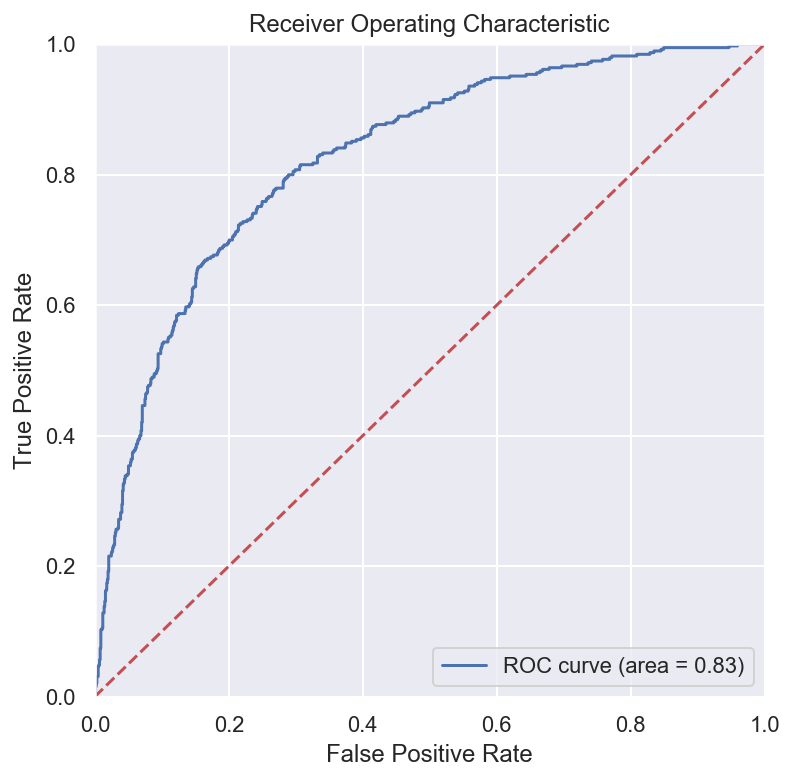


"""""" BernoulliNB """"""

Search for OPTIMAL THRESHOLD, vary from 0.001 to 0.999, fit/predict on train/test data

Iteration 1
0.0010->0.5744,  0.1008->0.6212,  0.2006->0.6242,  0.3004->0.6254,  0.4002->0.6283,  0.5000->0.6324,  0.5998->0.6318,  0.6996->0.6381,  0.7994->0.6403,  0.8992->0.6347,  0.9990->0.4602,  
Iteration 2
0.4000->0.6283,  0.4200->0.6322,  0.4400->0.6307,  0.4600->0.6306,  0.4800->0.6312,  0.5000->0.6324,  0.5200->0.6308,  0.5400->0.6321,  0.5600->0.6312,  0.5800->0.6298,  0.6000->0.6318,  
Iteration 3
0.4800->0.6312,  0.4810->0.6312,  0.4820->0.6319,  0.4830->0.6319,  0.4840->0.6326,  0.4850->0.6333,  0.4860->0.6333,  0.4870->0.6333,  0.4880->0.6339,  0.4890->0.6346,  0.4900->0.6346,  0.4910->0.6346,  0.4920->0.6346,  0.4930->0.6346,  0.4940->0.6317,  0.4950->0.6317,  0.4960->0.6324,  0.4970->0.6324,  0.4980->0.6324,  0.4990->0.6324,  0.5000->0.6324,  0.5010->0.6324,  0.5020->0.6324,  0.5030->0.6324,  0.5040->0.6324,  0.5050->0.6324,  0.5060->0.6324,  0.5070->0.632

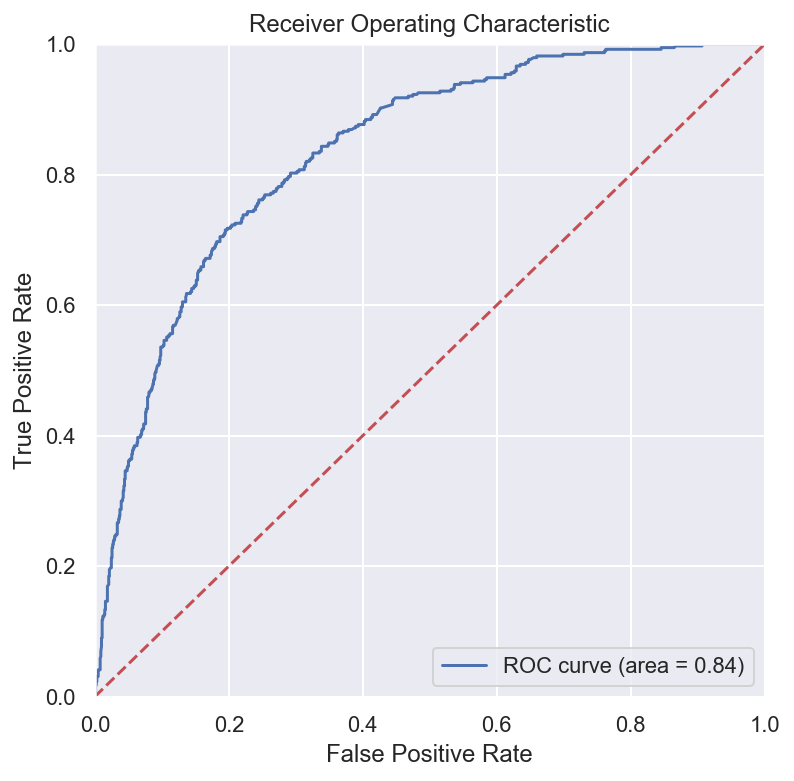

In [101]:
print('\n"""""" GaussianNB """"""')
time1 = time.time()
gnb = GaussianNB()
model_report('GaussianNB', gnb)

model_list.append('GaussianNB')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

print('\n"""""" BernoulliNB """"""')
time1 = time.time()
bnb = BernoulliNB()
model_report('BernoulliNB', bnb)

model_list.append('BernoulliNB')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

### this model does not work
# print('\n"""""" MultinomialNB """"""')
# mnb = MultinomialNB()
# model_report('MultinomialNB', mnb)


"""""" LogisticRegression """"""

Search for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data
0.4311, 0.4405, 0.4524, 0.4644, 0.4688, 0.4776, 0.4816, 0.4896, 0.4944, 0.5009, 0.5098, 0.5123, 0.5176, 0.5217, 0.5279, 0.5285, 0.5263, 0.5311, 0.5361, 0.5390, 0.5427, 0.5433, 0.5440, 0.5485, 0.5507, 0.5535, 0.5562, 0.5563, 0.5573, 0.5595, 0.5612, 0.5635, 0.5653, 0.5673, 0.5671, 0.5682, 0.5697, 0.5695, 0.5695, 0.5702, 0.5711, 0.5725, 0.5721, 0.5725, 0.5726, 0.5741, 0.5744, 0.5755, 0.5755, 0.5756, 0.5771, 0.5779, 0.5779, 0.5797, 0.5790, 0.5780, 0.5789, 0.5802, 0.5803, 0.5817, 0.5815, 0.5815, 0.5818, 0.5826, 0.5833, 0.5836, 0.5831, 0.5825, 0.5832, 0.5832, 0.5849, 0.5839, 0.5846, 0.5864, 0.5862, 0.5868, 0.5847, 0.5840, 0.5848, 0.5841, 0.5849, 0.5851, 0.5856, 0.5859, 0.5870, 0.5857, 0.5861, 0.5872, 0.5860, 0.5860, 0.5860, 0.5855, 0.5855, 0.5853, 0.5841, 0.5841, 0.5844, 0.5836, 0.5826, 0.5826, 0.5820, 0.5820, 0.5820, 0.5820, 

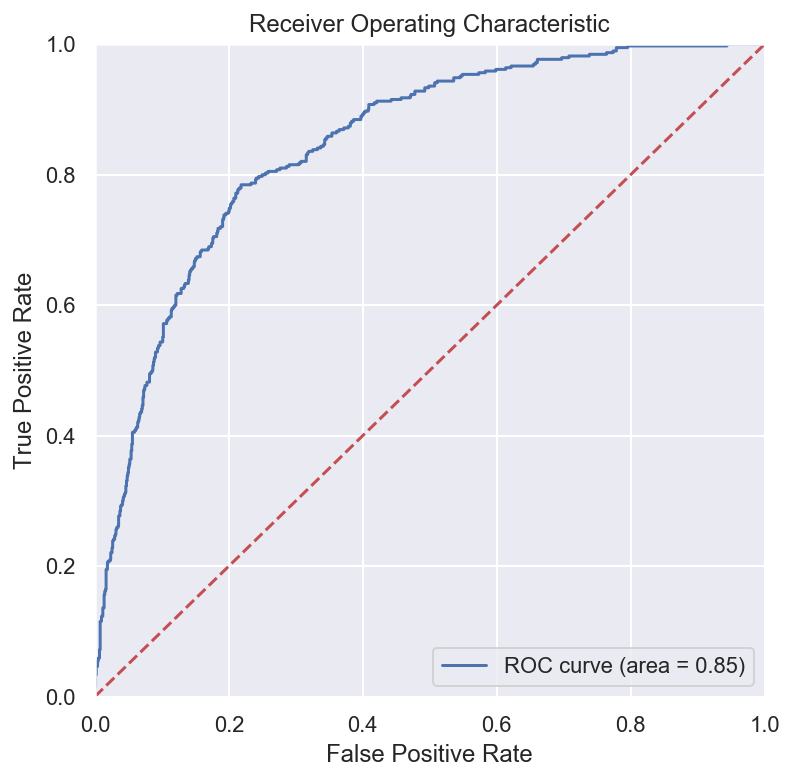

In [102]:
print('\n"""""" LogisticRegression """"""')
print('\nSearch for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=21, shuffle=True)  #produce the k folds
score_list = []
c_list = []
for c in 10**np.linspace(-3,3,200):
    logit = LogisticRegression(C = c)
    cvs = (cross_val_score(logit, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    c_list.append(c)
    print('{:.4f}'.format(cvs), end=", ")   # 4 decimal pl
print('optimal F1 score = {:.4f}'.format(max(score_list)))
optimal_c = float(c_list[score_list.index(max(score_list))])
print('optimal value of C = {:.4f}'.format(optimal_c))

time1 = time.time()
logit = LogisticRegression(C = optimal_c)
model_report('LogisticRegression', logit)

model_list.append('LogisticRegression')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

In [42]:
# logit = LogisticRegression(C = 0.1825)
# Adjust threshold to 0.3181:
# Precision: 0.5659,   Recall: 0.7787,   F1 Score: 0.6554
# Logistic confusion matrix: 
#  [[806 224]
#  [ 83 292]]
# Log-loss on logit: 0.4073


"""""" KNN """""" (quite slow)

Search for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data
0.4677, 0.3922, 0.5218, 0.4669, 0.5325, 0.4942, 0.5513, 0.5170, 0.5648, 0.5280, 0.5565, 0.5391, 0.5627, 0.5446, 0.5685, 0.5487, 0.5757, 0.5594, 0.5760, 0.5590, optimal F1 score = 0.5760
optimal value of K = 19

Search for OPTIMAL THRESHOLD, vary from 0.001 to 0.999, fit/predict on train/test data

Iteration 1
0.0010->0.5030,  0.1008->0.5451,  0.2006->0.5937,  0.3004->0.6293,  0.4002->0.6266,  0.5000->0.5947,  0.5998->0.4934,  0.6996->0.3386,  0.7994->0.1485,  0.8992->0.0353,  0.9990->0.0153,  
Iteration 2
0.4000->0.6266,  0.4200->0.6266,  0.4400->0.6292,  0.4600->0.6292,  0.4800->0.5947,  0.5000->0.5947,  0.5200->0.5947,  0.5400->0.5469,  0.5600->0.5469,  0.5800->0.4934,  0.6000->0.4934,  
Iteration 3
0.4800->0.5947,  0.4810->0.5947,  0.4820->0.5947,  0.4830->0.5947,  0.4840->0.5947,  0.4850->0.5947,  0.4860->0.5947,  0.4870->0.5947,  0.4880->0

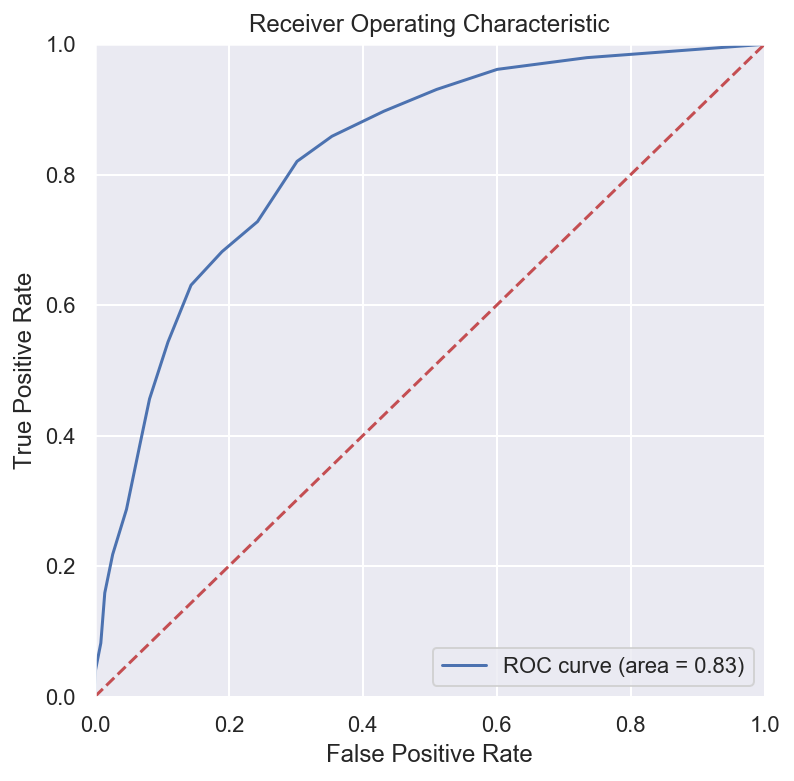


Compare with KNN classification_report (same as default threshold 0.50)
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1017
           1       0.66      0.54      0.59       390

    accuracy                           0.79      1407
   macro avg       0.75      0.72      0.73      1407
weighted avg       0.79      0.79      0.79      1407



In [97]:
print('\n"""""" KNN """""" (quite slow)')
print('\nSearch for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=21, shuffle=True)  #produce the k folds
k_scores = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors = k)
    cvs = cross_val_score(knn, X_train, y_train, cv=kf, scoring='f1').mean()
    k_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal F1 score = {:.4f}'.format(max(k_scores)))   # 4 decimal pl
optimal_k = k_scores.index(max(k_scores))+1   # index 0 is for k=1
print('optimal value of K =', optimal_k)

time1 = time.time()
knn = KNeighborsClassifier(n_neighbors = optimal_k)
model_report('KNN', knn)

print('\nCompare with KNN classification_report (same as default threshold 0.50)')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

model_list.append('KNN')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)


"""""" DecisionTreeClassifier """"""

Search for optimal max_depth in DecisionTree, vary from 2 to 10, using KFold(5) Cross Validation on train data
0.5787, 0.5062, 0.5626, 0.5613, 0.5640, 0.5642, 0.5320, 0.5336, 0.5319, optimal F1 score = 0.5787
optimal max_depth = 2

Search for OPTIMAL THRESHOLD, vary from 0.001 to 0.999, fit/predict on train/test data

Iteration 1
0.0010->0.4341,  0.1008->0.5480,  0.2006->0.5811,  0.3004->0.5911,  0.4002->0.5911,  0.5000->0.5911,  0.5998->0.0000,  0.6996->0.0000,  0.7994->0.0000,  0.8992->0.0000,  0.9990->0.0000,  
Iteration 2
0.4000->0.5911,  0.4200->0.5911,  0.4400->0.5911,  0.4600->0.5911,  0.4800->0.5911,  0.5000->0.5911,  0.5200->0.5911,  0.5400->0.5911,  0.5600->0.0000,  0.5800->0.0000,  0.6000->0.0000,  
Iteration 3
0.4800->0.5911,  0.4810->0.5911,  0.4820->0.5911,  0.4830->0.5911,  0.4840->0.5911,  0.4850->0.5911,  0.4860->0.5911,  0.4870->0.5911,  0.4880->0.5911,  0.4890->0.5911,  0.4900->0.5911,  0.4910->0.5911,  0.4920->0.5911,  0.4930->

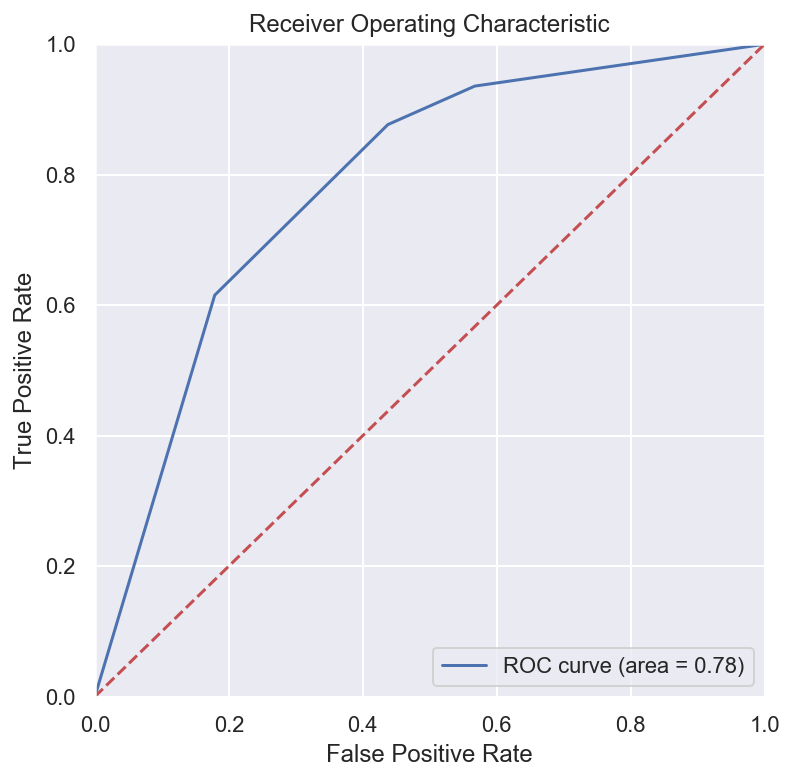

In [98]:
print('\n"""""" DecisionTreeClassifier """"""')

print('\nSearch for optimal max_depth in DecisionTree, vary from 2 to 10, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=21, shuffle=True)  #produce the k folds
d_scores = []
for d in range(2, 11):
    decisiontree = DecisionTreeClassifier(max_depth=d)
    cvs = cross_val_score(decisiontree, X_train, y_train, cv=kf, scoring='f1').mean()
    d_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal F1 score = {:.4f}'.format(max(d_scores)))   # 4 decimal pl
optimal_d = d_scores.index(max(d_scores))+2   # index 0 is for d=2
print('optimal max_depth =', optimal_d)

time1 = time.time()
decisiontree = DecisionTreeClassifier(max_depth=optimal_d)
model_report('DecisionTreeClassifier', decisiontree)

model_list.append('DecisionTreeClassifier')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)

In [ ]:
# Optimal threshold 0.2866
# Precision: 0.5687,   Recall: 0.6154,   F1 Score: 0.5911
# DecisionTreeClassifier confusion matrix: 
#  [[835 182]
#  [150 240]]


"""""" RandomForestClassifier """""" (quite slow)

Search for optimal n_estimators in RandomForest, vary from , using KFold(5) Cross Validation on train data
100->0.5371, 150->0.5480, 200->0.5466, 250->0.5471, 300->0.5452, 350->0.5518, 400->0.5472, 450->0.5473, 500->0.5454, optimal F1 score = 0.5518
optimal n_estimators = 350.0000

Search for OPTIMAL THRESHOLD, vary from 0.001 to 0.999, fit/predict on train/test data

Iteration 1
0.0010->0.4606,  0.1008->0.5679,  0.2006->0.6113,  0.3004->0.6271,  0.4002->0.6138,  0.5000->0.5639,  0.5998->0.4847,  0.6996->0.3514,  0.7994->0.2527,  0.8992->0.1324,  0.9990->0.0051,  
Iteration 2
0.4000->0.6150,  0.4200->0.6061,  0.4400->0.5970,  0.4600->0.5967,  0.4800->0.5941,  0.5000->0.5639,  0.5200->0.5507,  0.5400->0.5412,  0.5600->0.5256,  0.5800->0.5083,  0.6000->0.4847,  
Iteration 3
0.4800->0.5941,  0.4810->0.5929,  0.4820->0.5929,  0.4830->0.5886,  0.4840->0.5886,  0.4850->0.5886,  0.4860->0.5854,  0.4870->0.5854,  0.4880->0.5854,  0.4890->0.58

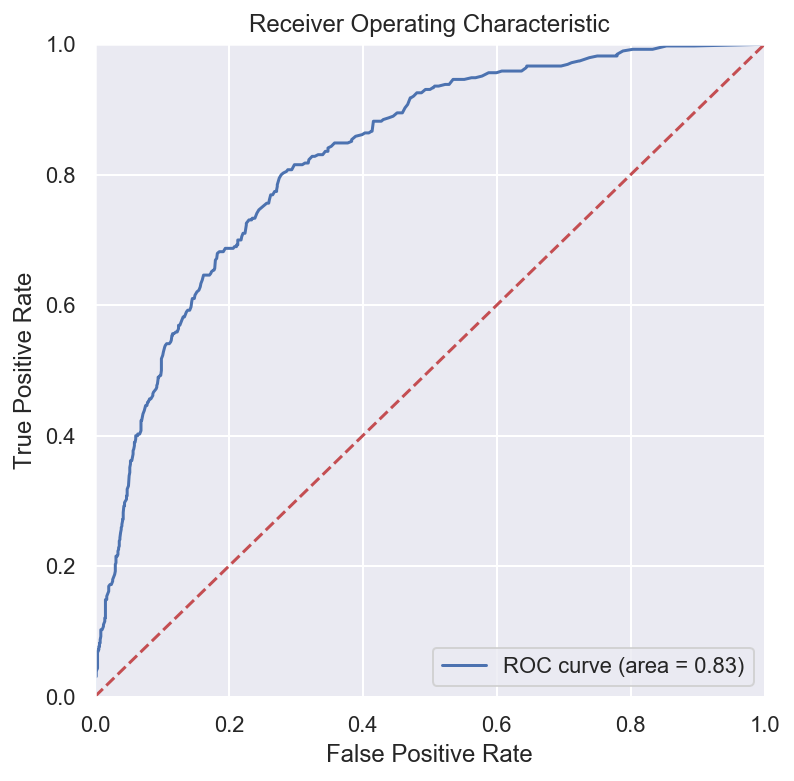

In [99]:
print('\n"""""" RandomForestClassifier """""" (quite slow)')

print('\nSearch for optimal n_estimators in RandomForest, vary from , using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=21, shuffle=True)  #produce the k folds
score_list = []
n_list = []
for n in [100, 150, 200, 250, 300, 350, 400, 450, 500]:
    randomforest = RandomForestClassifier(n_estimators=n)
    cvs = (cross_val_score(randomforest, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    n_list.append(n)
    print('{:.0f}->{:.4f}'.format(n, cvs), end=", ")   # 4 decimal pl
print('optimal F1 score = {:.4f}'.format(max(score_list)))
optimal_n = int(n_list[score_list.index(max(score_list))])
print('optimal n_estimators = {:.4f}'.format(optimal_n))

time1 = time.time()
randomforest = RandomForestClassifier(n_estimators=optimal_n)
model_report('RandomForestClassifier', randomforest)

model_list.append('RandomForestClassifier')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)


"""""" LinearSVC """"""
LinearSVC accuracy score is
Training: 80.59%
Test set: 79.74%
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1017
           1       0.69      0.48      0.57       390

    accuracy                           0.80      1407
   macro avg       0.76      0.70      0.72      1407
weighted avg       0.79      0.80      0.79      1407

LinearSVC confusion matrix: 
 [[933  84]
 [201 189]]
LinearSVC Log-loss: 6.9962
LinearSVC roc_auc_score: 0.7010
LinearSVC AUC: 0.7010


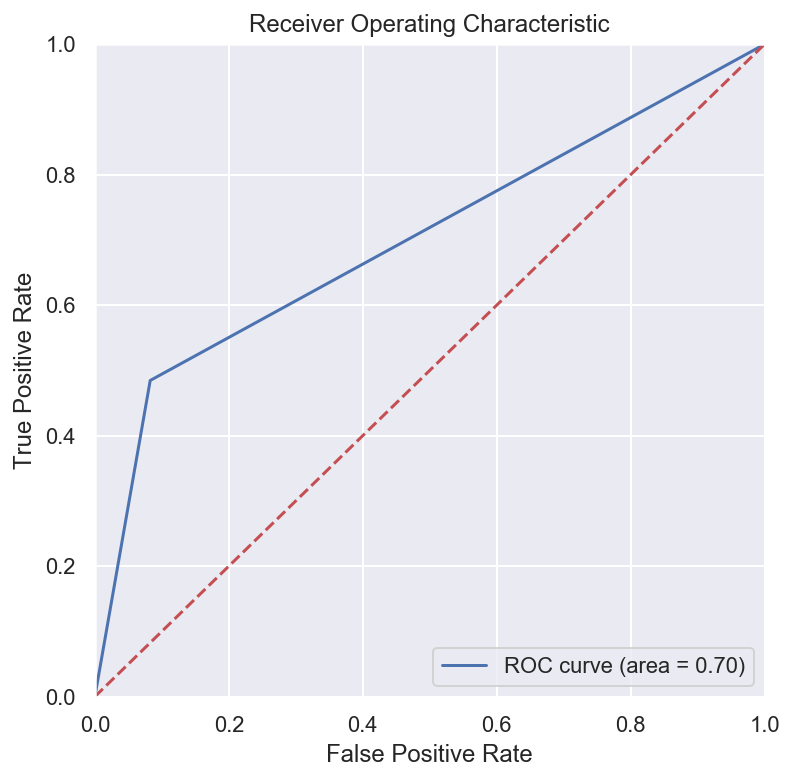

In [103]:
print('\n"""""" LinearSVC """"""')
time1 = time.time()
linearsvc = LinearSVC()
# model_report('LinearSVC', linearsvc)   # model has no attribute 'predict_proba'
linearsvc.fit(X_train, y_train)
print('LinearSVC accuracy score is')
print('Training: {:.2f}%'.format(100*linearsvc.score(X_train, y_train)))  # score uses accuracy
print('Test set: {:.2f}%'.format(100*linearsvc.score(X_test, y_test)))   # should use cross validation

y_pred = linearsvc.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print('LinearSVC confusion matrix: \n', confusion_matrix(y_test, y_pred))

model_f1 = f1_score(y_test, y_pred)

model_ll = log_loss(y_test, y_pred)
print('LinearSVC Log-loss: {:.4f}'.format(model_ll))
model_roc_auc = roc_auc_score(y_test, y_pred)
print('LinearSVC roc_auc_score: {:.4f}'.format(model_roc_auc)) 
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
model_auc = auc(fpr, tpr)
print('LinearSVC AUC: {:.4f}'.format(model_auc))

# plot the ROC curve
plt.figure(figsize = [6,6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % model_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
# plt.savefig('roc_auc_score')
plt.show()

model_list.append('LinearSVC')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
time_list.append(time.time() - time1)


"""""" SVC """""" (extremely slow)

Search for OPTIMAL THRESHOLD, vary from 0.001 to 0.999, fit/predict on train/test data

Iteration 1
0.0010->0.4341,  0.1008->0.4360,  0.2006->0.6347,  0.3004->0.6182,  0.4002->0.5723,  0.5000->0.5387,  0.5998->0.4765,  0.6996->0.3569,  0.7994->0.1826,  0.8992->0.0153,  0.9990->0.0000,  
Iteration 2
0.4000->0.5723,  0.4200->0.5640,  0.4400->0.5550,  0.4600->0.5463,  0.4800->0.5463,  0.5000->0.5387,  0.5200->0.5320,  0.5400->0.5232,  0.5600->0.5068,  0.5800->0.4914,  0.6000->0.4765,  
Iteration 3
0.4800->0.5463,  0.4810->0.5472,  0.4820->0.5449,  0.4830->0.5449,  0.4840->0.5449,  0.4850->0.5425,  0.4860->0.5425,  0.4870->0.5425,  0.4880->0.5434,  0.4890->0.5411,  0.4900->0.5411,  0.4910->0.5387,  0.4920->0.5387,  0.4930->0.5387,  0.4940->0.5387,  0.4950->0.5387,  0.4960->0.5387,  0.4970->0.5387,  0.4980->0.5387,  0.4990->0.5387,  0.5000->0.5387,  0.5010->0.5348,  0.5020->0.5348,  0.5030->0.5348,  0.5040->0.5348,  0.5050->0.5348,  0.5060->0.5357,  0.50

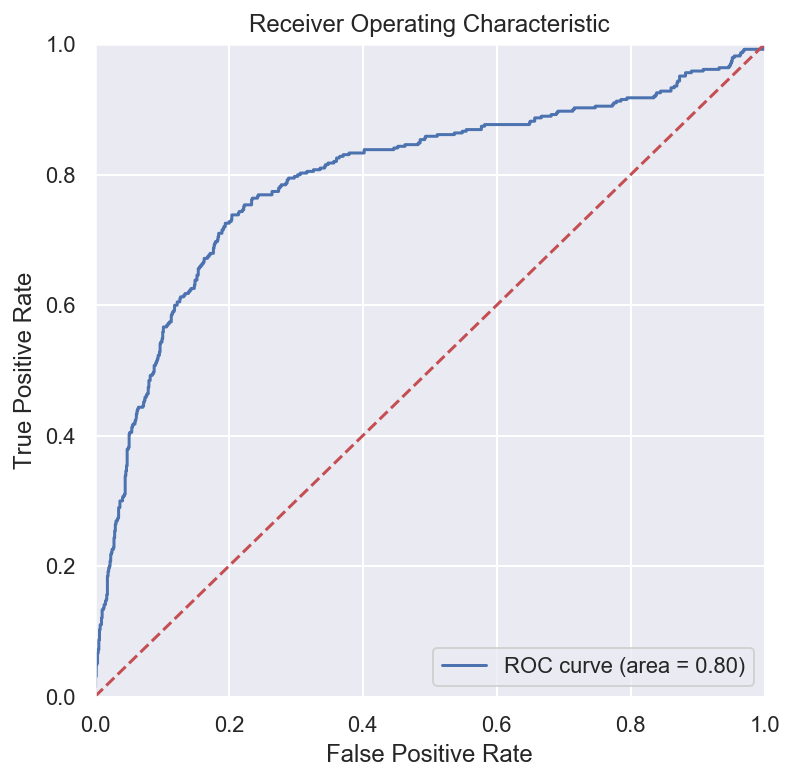

In [104]:
print('\n"""""" SVC """""" (extremely slow)')
time1 = time.time()
svc = SVC(gamma='scale', probability=True)
model_report('SVC', svc)

model_list.append('SVC')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
# time_list.append(time.time() - time1)   # use this line for actual time spent
time_list.append(0)   # use this line to be able to see time spent for other models

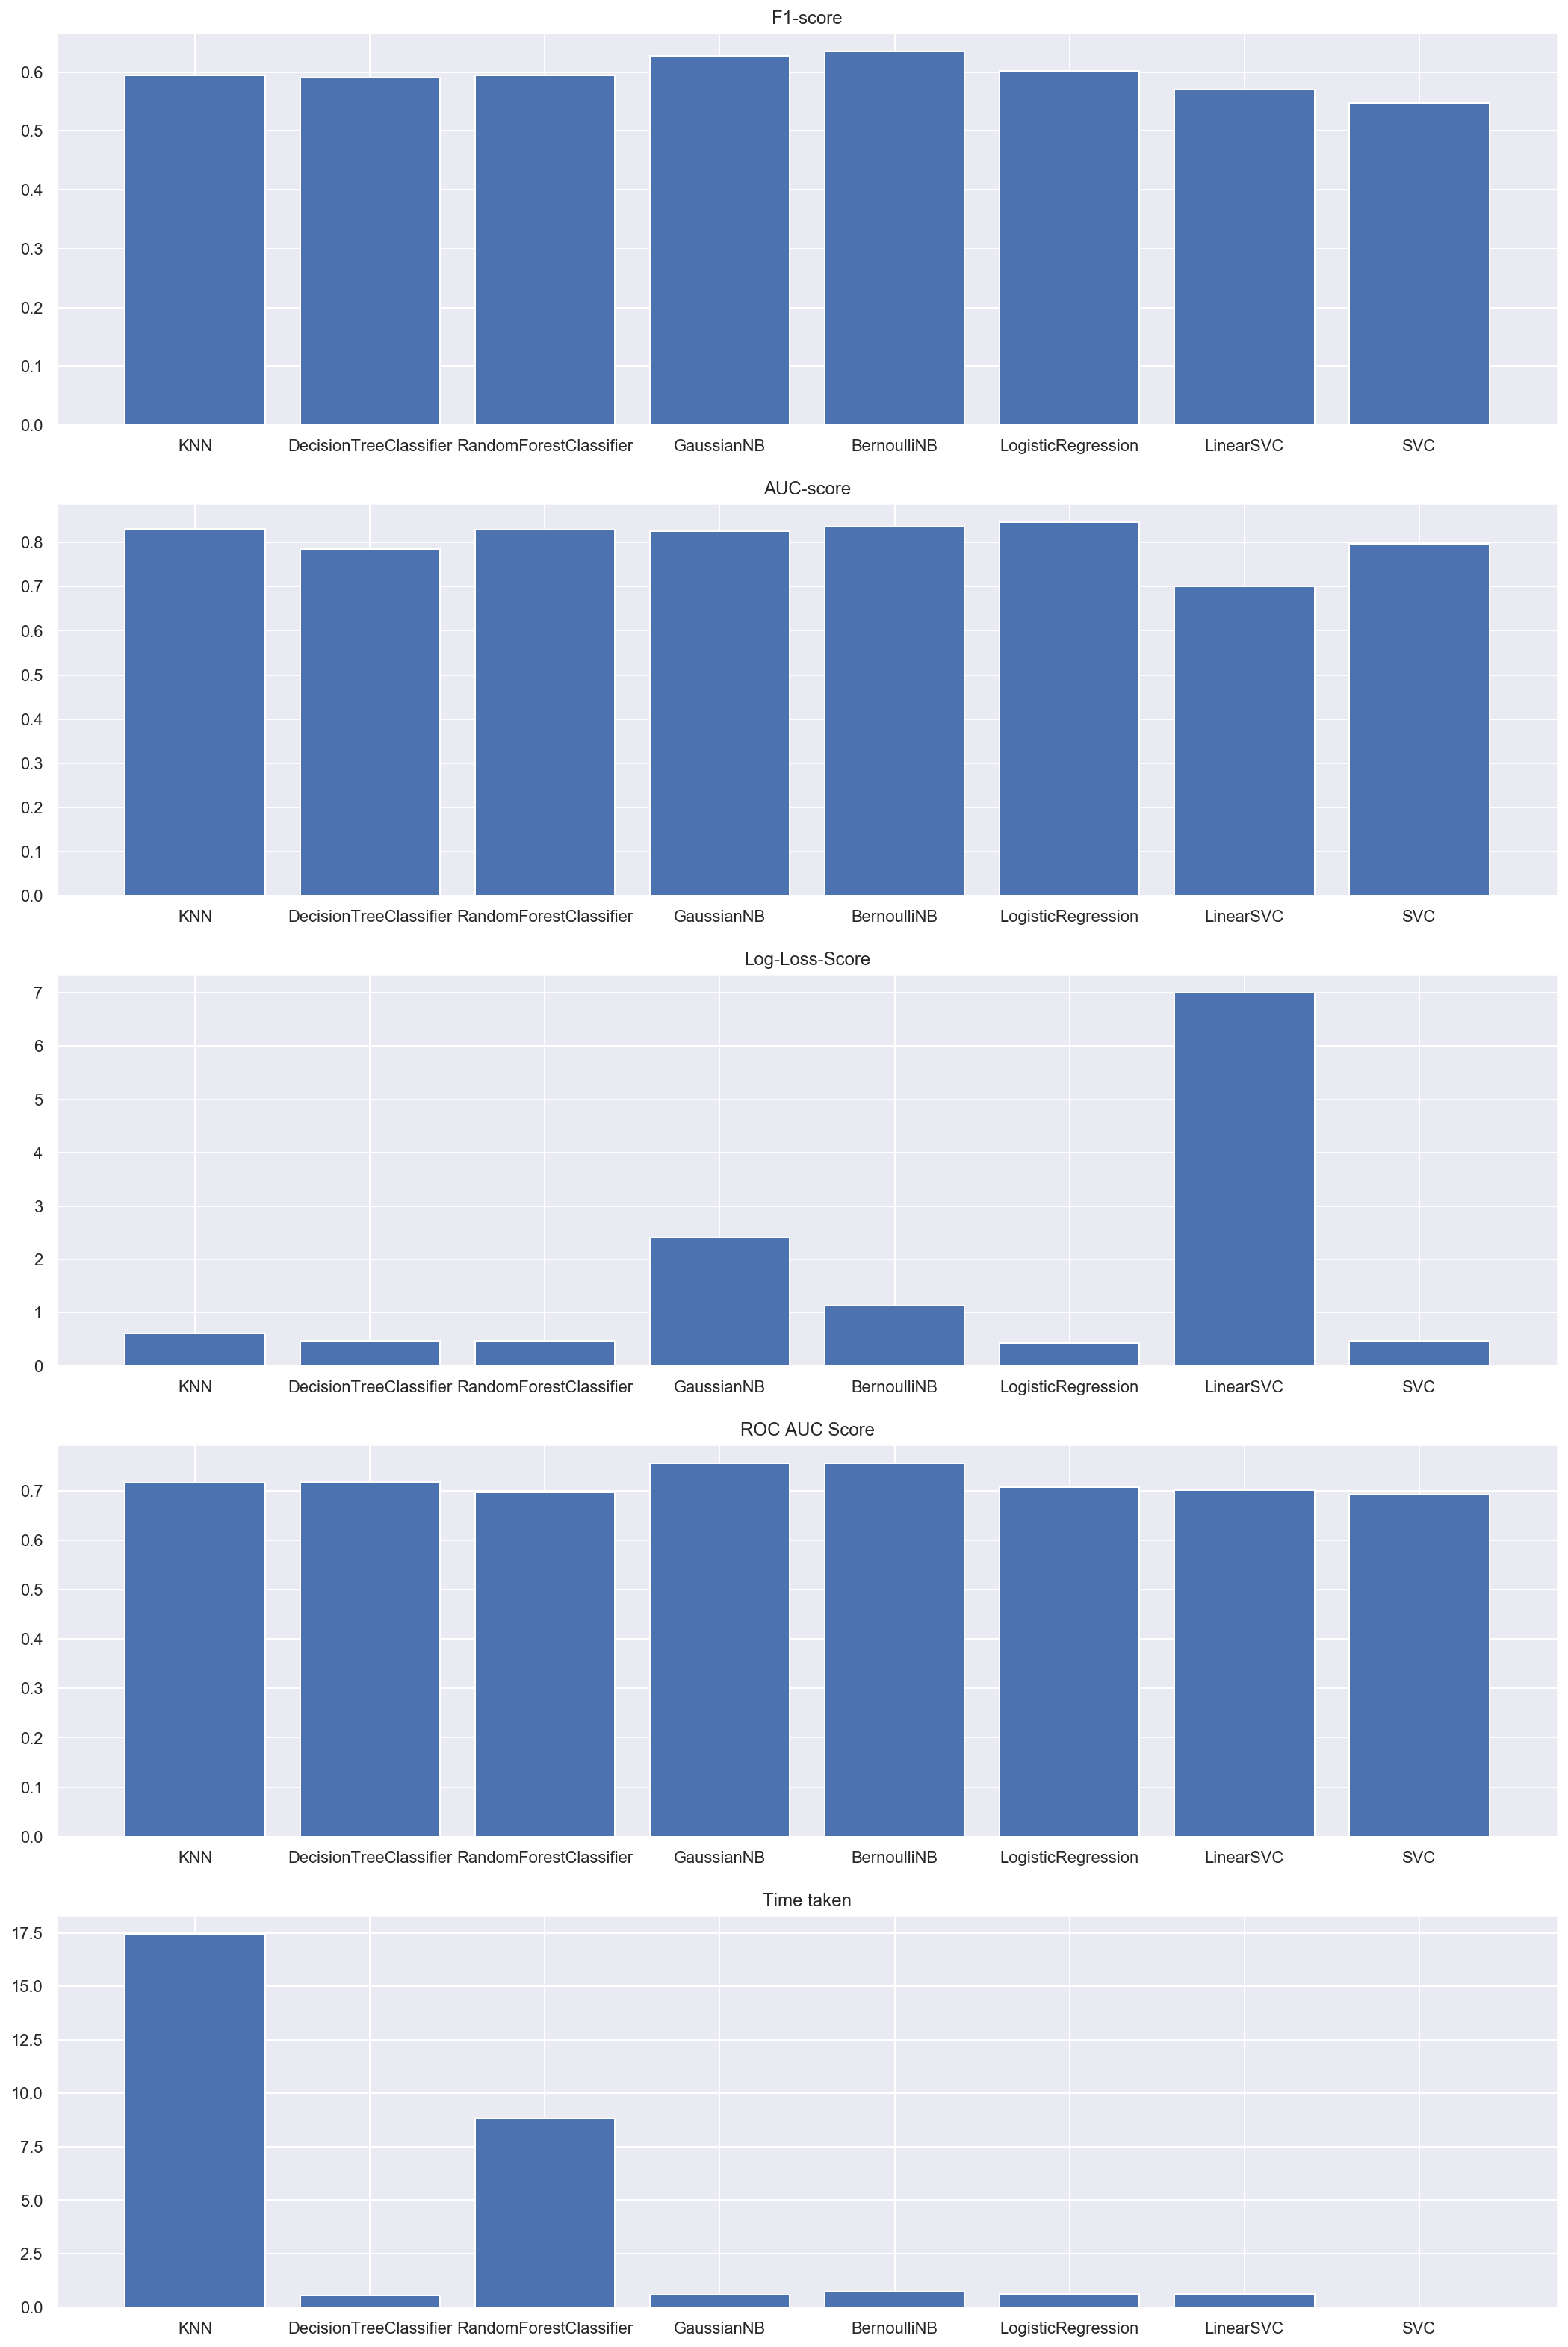

In [105]:
## plot the classification report scores
fig, ax = plt.subplots(5, 1, figsize=(18, 28))
# fig.set_figwidth(10)
# fig.set_figheight(6)
# fig.suptitle('Main Title',fontsize = 16)
ax[0].bar(model_list, f1_list)
ax[0].set_title('F1-score')
ax[1].bar(model_list, auc_list)
ax[1].set_title('AUC-score');
ax[2].bar(model_list, ll_list)
ax[2].set_title('Log-Loss-Score')
ax[3].bar(model_list, roc_auc_list)
ax[3].set_title('ROC AUC Score')
ax[4].bar(model_list, time_list)
ax[4].set_title('Time taken')
# Fine-tune figure; make subplots farther from each other, or nearer to each other.
fig.subplots_adjust(hspace=0.2, wspace=0.2)

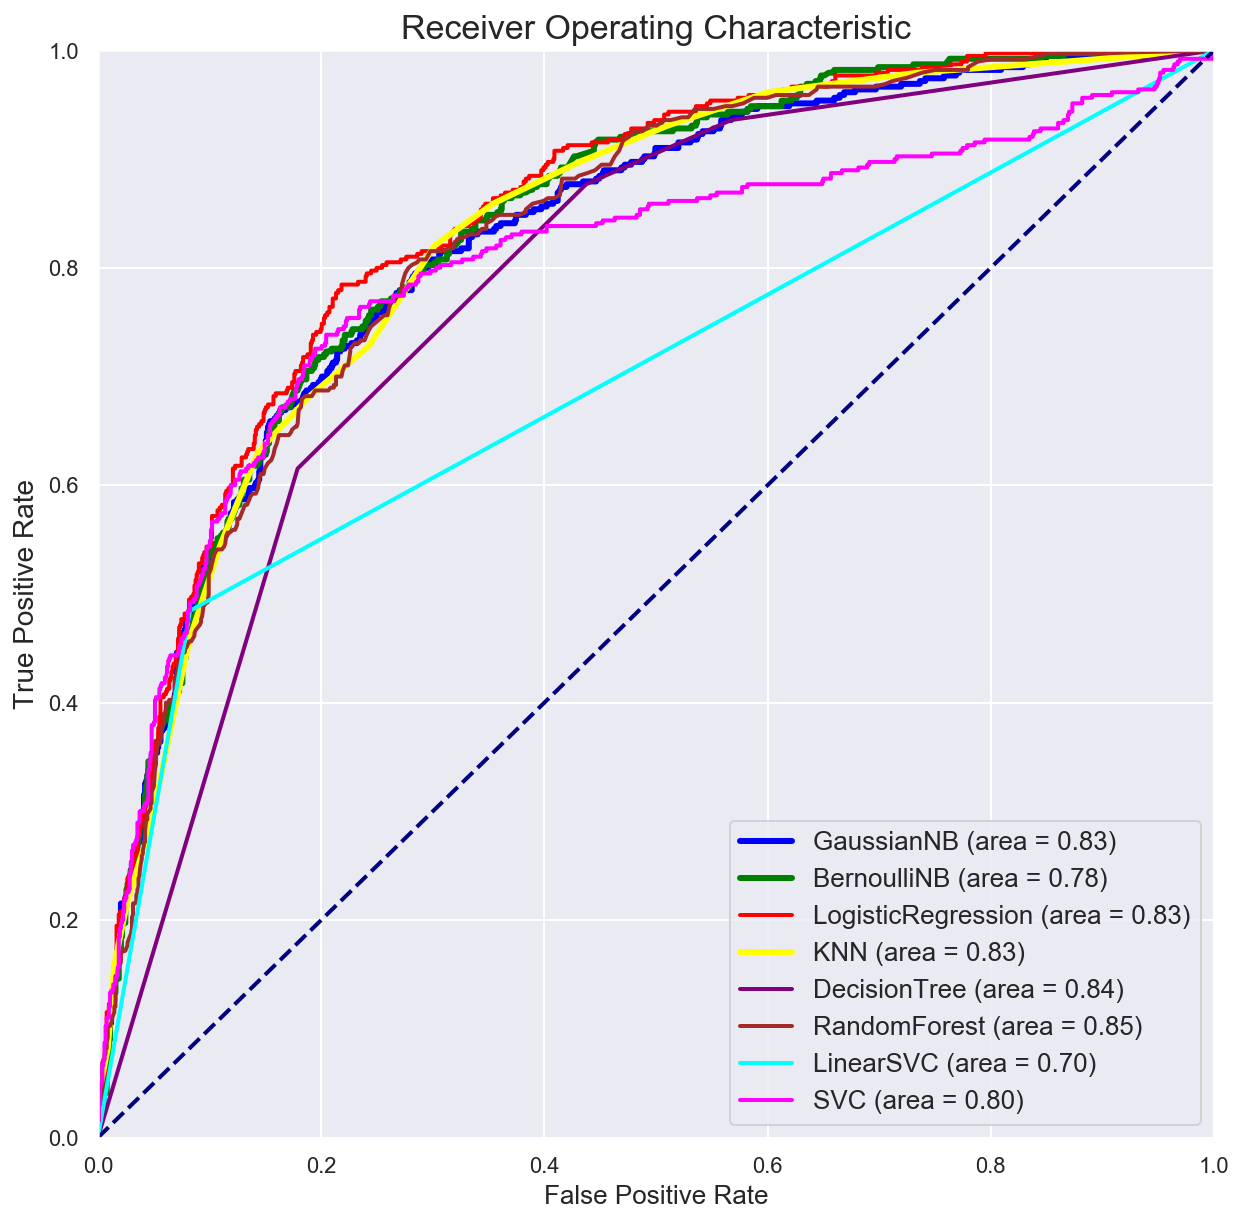

In [106]:
# plot the ROC curves
plt.figure(figsize=(10,10))

y_pred = gnb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='blue',
        lw=3, label='GaussianNB (area = %0.2f)' % auc_list[0])

y_pred = bnb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='green',
        lw=3, label='BernoulliNB (area = %0.2f)' % auc_list[1])

y_pred = logit.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red',
        lw=2, label='LogisticRegression (area = %0.2f)' % auc_list[2])

y_pred = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='yellow',
        lw=3, label='KNN (area = %0.2f)' % auc_list[3])

y_pred = decisiontree.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='purple',
        lw=2, label='DecisionTree (area = %0.2f)' % auc_list[4])

y_pred = randomforest.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='brown',
        lw=2, label='RandomForest (area = %0.2f)' % auc_list[5])

y_pred = linearsvc.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='cyan',
        lw=2, label='LinearSVC (area = %0.2f)' % auc_list[6])

y_pred = svc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='magenta',
        lw=2, label='SVC (area = %0.2f)' % auc_list[7])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [50]:
# see how logistic regression confusion matrix varies with threshold
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_pred = (logit.predict_proba(X_test)[:, 1] >= threshold)
    conf = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = [5,5])
    sns.heatmap(conf, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['no churn', 'churn'],
           yticklabels=['no churn', 'churn']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
# Let's see how our confusion matrix changes with changes to the cutoff! 
from ipywidgets import interactive, FloatSlider
logit = LogisticRegression(C = optimal_c)
logit.fit(X_train, y_train)
interactive(lambda threshold: make_confusion_matrix(logit, threshold), threshold=(0.0,1.0,0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [51]:
# Optimal threshold 0.318
# Precision: 0.5812,   Recall: 0.7615,   F1 Score: 0.6593
# LogisticRegression confusion matrix: 
#  [[803 214]
#  [ 93 297]]